In [219]:
from Utils import *
from ml_utils import *
from Futu_Utils import *
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# from pandas import read_csv
# from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns; sns.set(style="whitegrid")

In [163]:
target_list=['^HSI','2800.HK','7500.HK','3067.HK','3033.HK','3032.HK','7226.HK','7200.HK','^HSCE','2828.HK','7552.HK','7226.HK','3088.HK']
target_list=list(set(target_list))
target_list_futu=list(pd.Series(target_list).apply(lambda x:'HK.0'+x[:-3] if x[-2:]=='HK' else x))
target_list.sort()
target_list_futu=['HK.800000' if x=='^HSI' else 'HK.02828' if x=='^HSCE' else x for x in target_list_futu]
target_list_futu.append('HK.HSImain')
target_list_futu.append('HK.HTImain')
target_list_futu.append('HK.HHImain')
target_list_futu.append('HK.800100')
target_list_futu=list(set(target_list_futu))

In [164]:
df_futu=get_history(target_list_futu,start='2015-01-01',end='2022-04-20',frequency='day')
df_futu_original=df_futu.set_index(['time_key','code']).unstack(1)
df_futu=df_futu_original['close'].copy()

2022-05-02 23:55:51,932 | 12343 | [open_context_base.py] _send_init_connect_sync:308: InitConnect ok: conn_id=5, host=127.0.0.1, port=11111, user_id=11959962
2022-05-02 23:55:55,554 | 12343 | [open_context_base.py] on_disconnect:380: Disconnected: conn_id=5


request successfully


## if you want to test run the code yourself you may start from here

In [16]:
df1=yf.download(target_list,period='10y',auto_adjust=True,threads=True)['Close']
df2=pd.read_parquet('Data/Daily Data/ETF daily.parquet')
df3=df_futu.copy()

[*********************100%***********************]  12 of 12 completed


In [167]:
#Choose the data source from futu
df=df3.copy()
data=df3.copy()

## Correlation and Preliminary Data Screening

In [18]:
# df_original.to_csv('10 year Data.csv')

In [168]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
def find_cointegrated_pairs(data,pvalue_thres):
        n = data.shape[1]
        score_matrix = np.zeros((n, n))
        pvalue_matrix = np.ones((n, n))
        keys = data.keys()
        pairs = []
        for i in range(n):
            for j in range(i+1, n):
                S1 = data[[keys[i],keys[j]]].dropna()[keys[i]]
                S2 = data[[keys[i],keys[j]]].dropna()[keys[j]]
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                if pvalue < pvalue_thres:
                    pairs.append((keys[i], keys[j]))
        return score_matrix, pvalue_matrix, pairs
def display_cointegrated_pairs(df,pvalue=0.02):
    scores, pvalues, pairs = find_cointegrated_pairs(df,pvalue)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(pvalues, xticklabels=list(df.columns), yticklabels=list(df.columns), cmap='RdYlGn_r' 
                    , mask = (pvalues >= pvalue),ax=ax)
    plt.show()
    return pairs,pd.DataFrame(pvalues,index=df.columns,columns=df.columns)

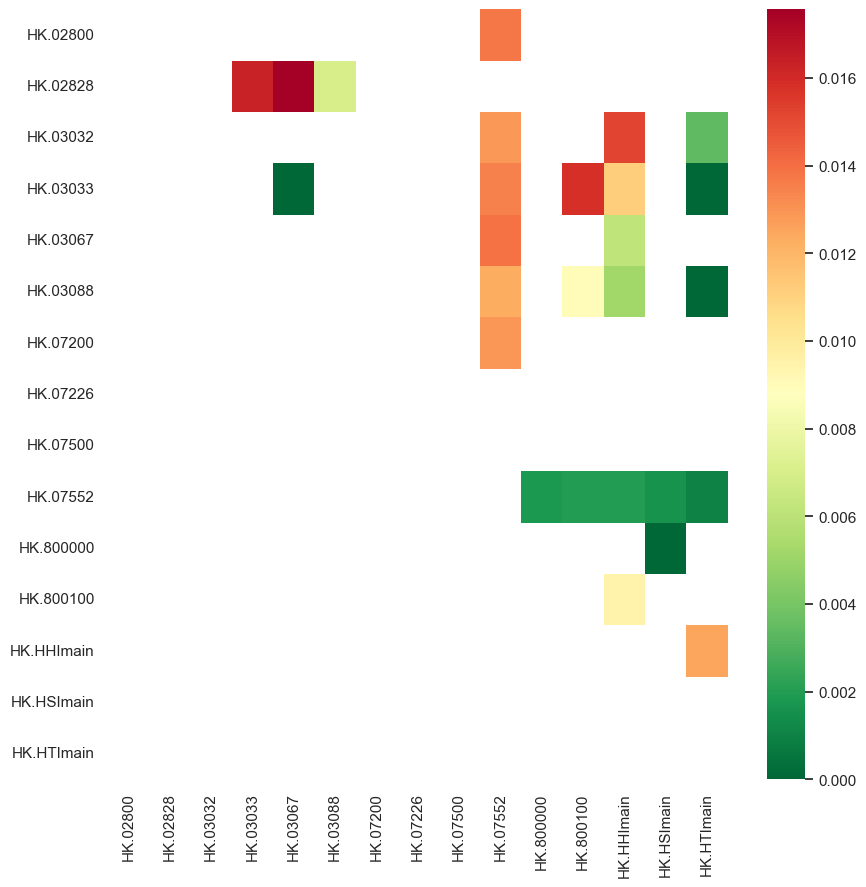

In [169]:
pairs,pvalues=display_cointegrated_pairs(df.loc[df.index.year>2017])

In [170]:
pairs_list=pairs.copy()

<AxesSubplot:xlabel='code', ylabel='code'>

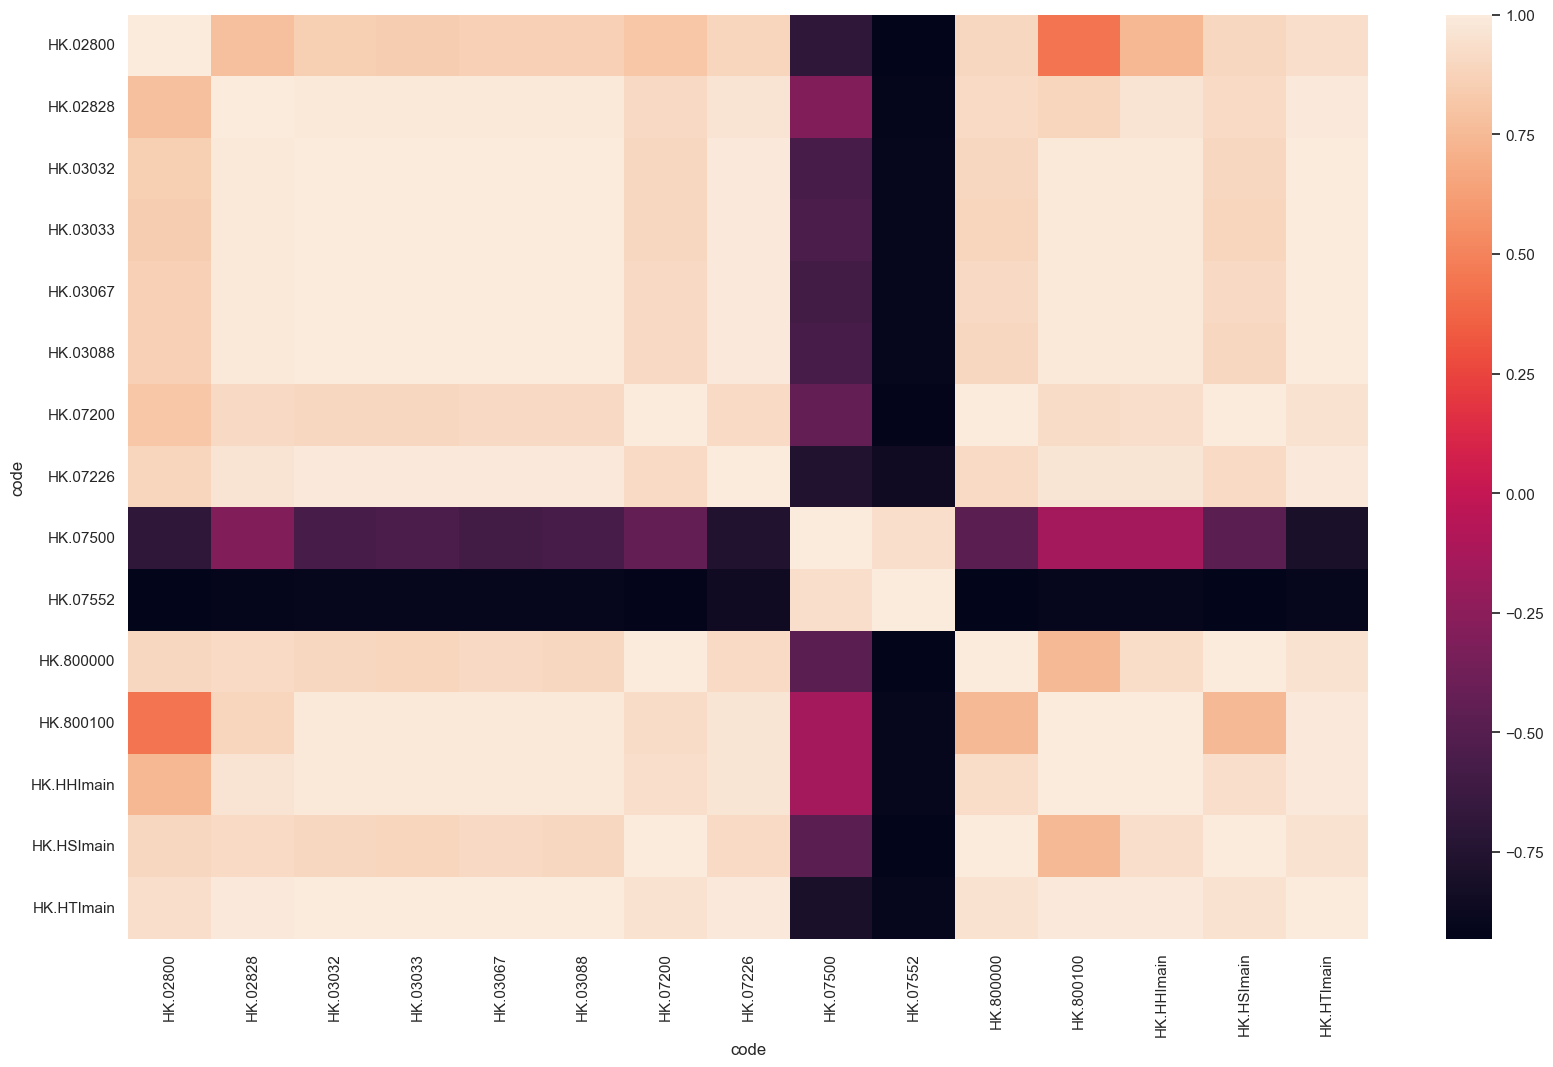

<AxesSubplot:xlabel='code', ylabel='code'>

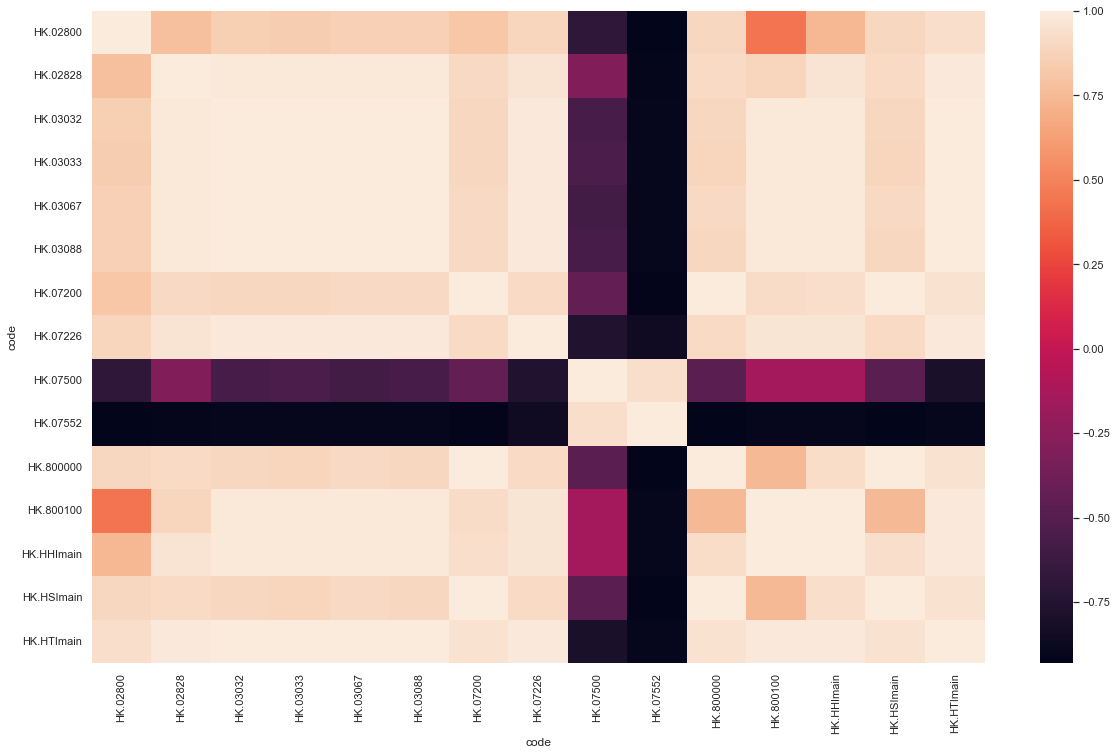

In [10]:
#check correlation
corr_df=df.corr()
log_ret=df.apply(lambda x:np.log(x/x.shift(1)))
log_ret=log_ret.loc[log_ret.index.year>2015]
plt.figure(figsize=(20,12))
sns.heatmap(corr_df)

In [174]:
#check Cumulative Log return 
plot_line(log_ret.cumsum(),title='Cumulative Log Return Series',xlabel='Time',ylabel='Cumulative Log Return',figsize=(20*0.9,20*0.618*0.9))

In [172]:
p_value_rank=pd.DataFrame()
for name1,name2 in pairs_list:
    p=pvalues.loc[name1][name2]
    p_value_rank=pd.concat([p_value_rank,pd.DataFrame([name1,name2,p])],axis=1)
p_value_rank=p_value_rank.T
p_value_rank.sort_values(2,inplace=True)
p_value_rank.columns=['name1','name2','p']
p_value_rank.head(5)

,name1,name2,p
0,HK.03033,HK.HTImain,0.0
0,HK.03033,HK.03067,0.0
0,HK.800000,HK.HSImain,0.0
0,HK.03088,HK.HTImain,0.0
0,HK.07552,HK.HTImain,0.000968


## Here we choose the pair HK.3033 and HK.3067

In [184]:
name1,name2=('HK.03033', 'HK.03067')
target_series1=log_ret[name1]
target_series2=log_ret[name2]
temp=log_ret[[name1,name2]]
diff=target_series1-target_series2
cum_diff=diff.cumsum()
transcost=3/10000

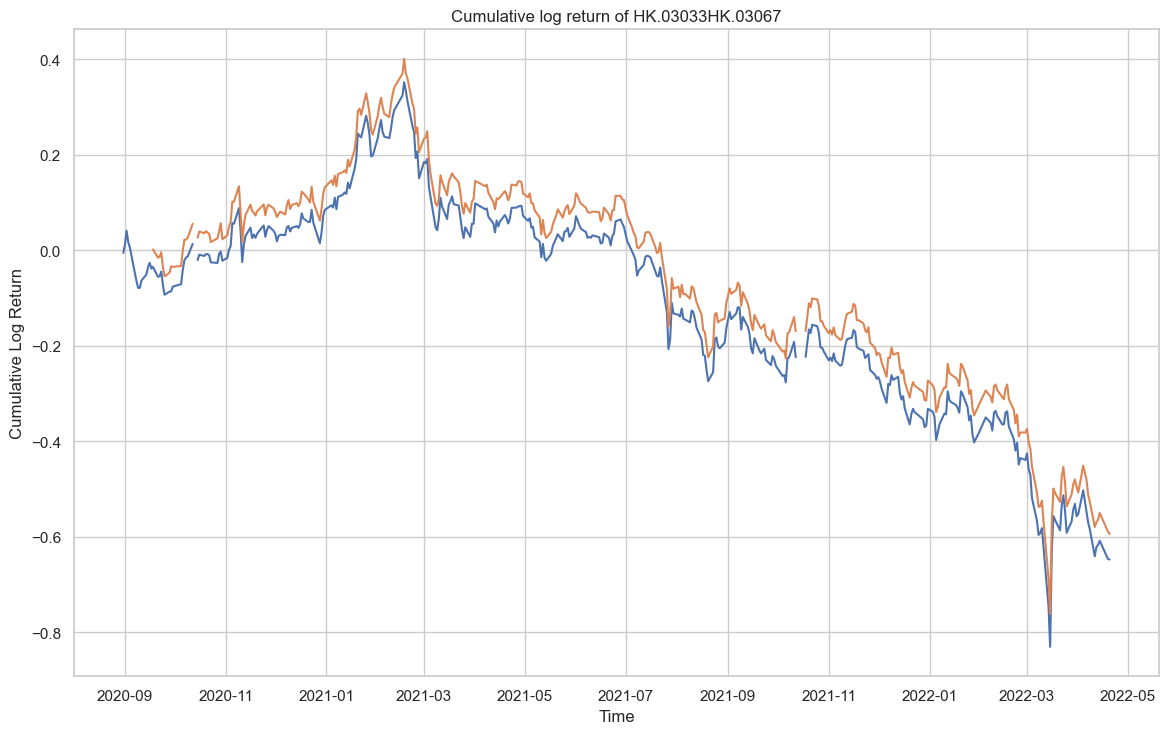

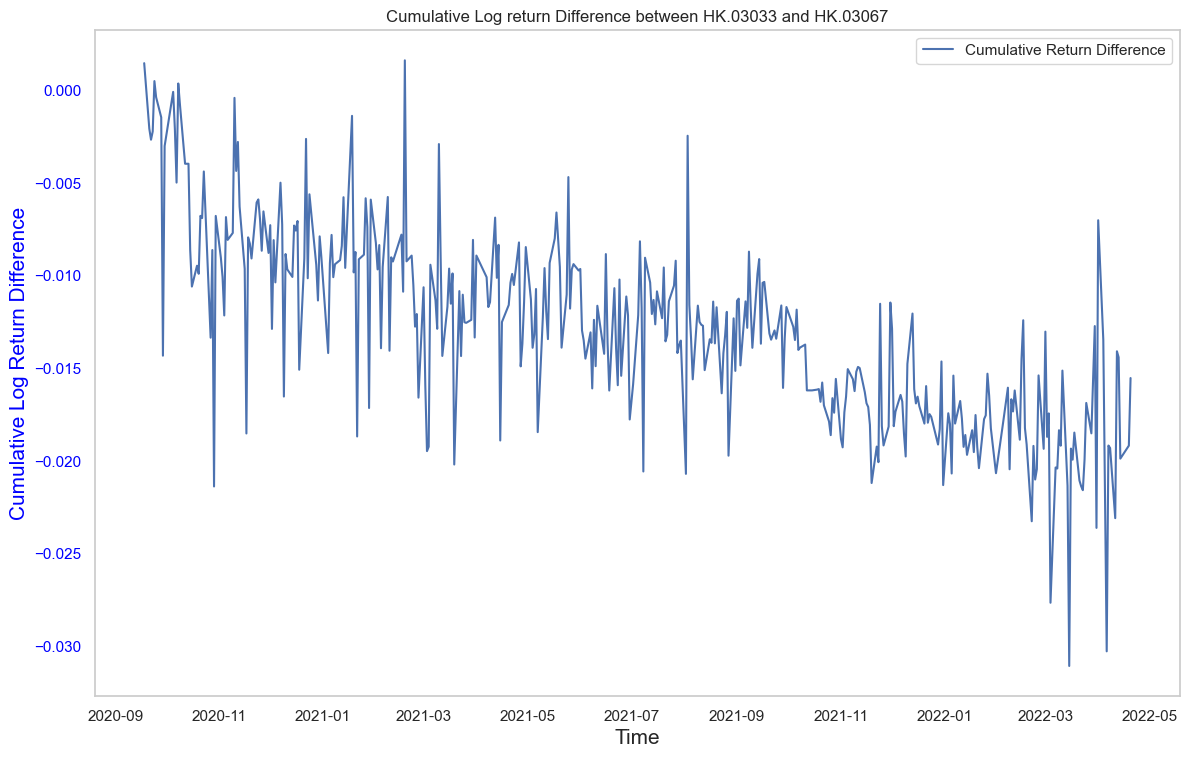

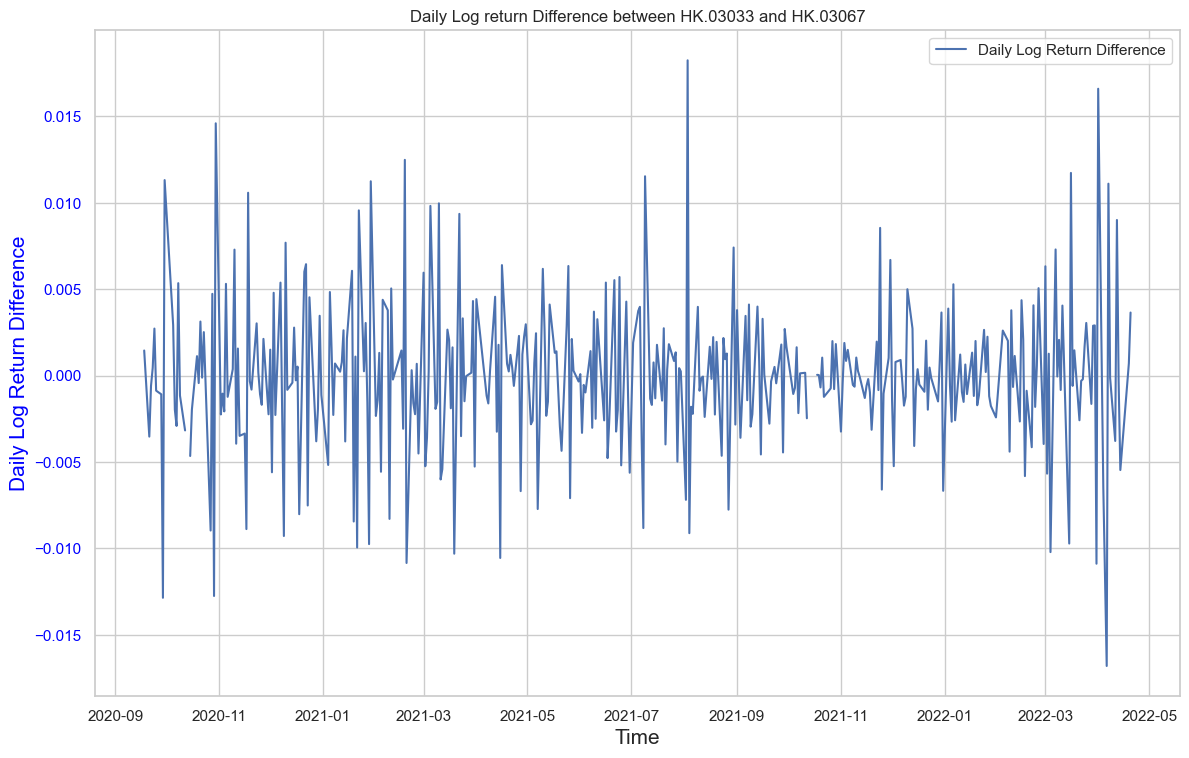

In [183]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20*0.7,12*0.7))

# plt.title('Cumulative Log Return Series of 3033.HK and 3067.HK')
plt.plot(temp.cumsum())
plt.title('Cumulative log return of '+name1+name2)
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
# plt.grid()
cum_diff=(temp.iloc[:,0]-temp.iloc[:,1]).cumsum().fillna(method='ffill')
plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(20*0.7,20*0.618*0.7))
plot_line(cum_diff.rename('Cumulative Return Difference'),title='Cumulative Log return Difference between '+name1+' and '+name2,xlabel='Time',ylabel='Cumulative Log Return Difference',figsize=(20*0.7,20*0.618*0.7),fontsize=15)
log_ret_1=(temp.iloc[:,0]-temp.iloc[:,1])
plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(20*0.7,20*0.618*0.7))
plot_line(log_ret_1.rename('Daily Log Return Difference'),title='Daily Log return Difference between '+name1+' and '+name2,xlabel='Time',ylabel='Daily Log Return Difference',figsize=(20*0.7,20*0.618*0.7),fontsize=15,grid=False)


In [185]:
def resid_analysis(resid,lags=20):
    from scipy.stats import shapiro
    df = resid.dropna()
    fig, axes = plt.subplots(3, 3,figsize=(25,13))
    axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
    plot_acf(df.dropna().values, ax=axes[0, 1],zero=False,lags=np.arange(1,lags))
    plot_pacf(df.dropna().values, ax=axes[0, 2],zero=False,lags=np.arange(1,lags))
    
    axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df.diff().dropna().values, ax=axes[1, 1],zero=False,lags=np.arange(1,lags))
    plot_pacf(df.diff().dropna(), ax=axes[1, 2],zero=False,lags=np.arange(1,lags))

    # 2nd Differencing
    axes[2, 0].plot(df.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df.diff().diff().dropna().values, ax=axes[2, 1],zero=False,lags=np.arange(1,lags))
    plot_pacf(df.diff().diff().dropna(), ax=axes[2, 2],zero=False,lags=np.arange(1,lags))
    plt.show()
    fig, axes = plt.subplots(1, 3,figsize=(23,7))
    resid.hist(ax=axes[0])
    resid.plot.kde(ax=axes[0])
    qqplot(resid.dropna(),line='s',ax=axes[1])
    resid.plot(ax=axes[2])
    plt.show()
    print('Shapiro-Wilk test result: '+str(shapiro(resid.dropna()).statistic)+' /  '+str(shapiro(resid.dropna()).pvalue))
    

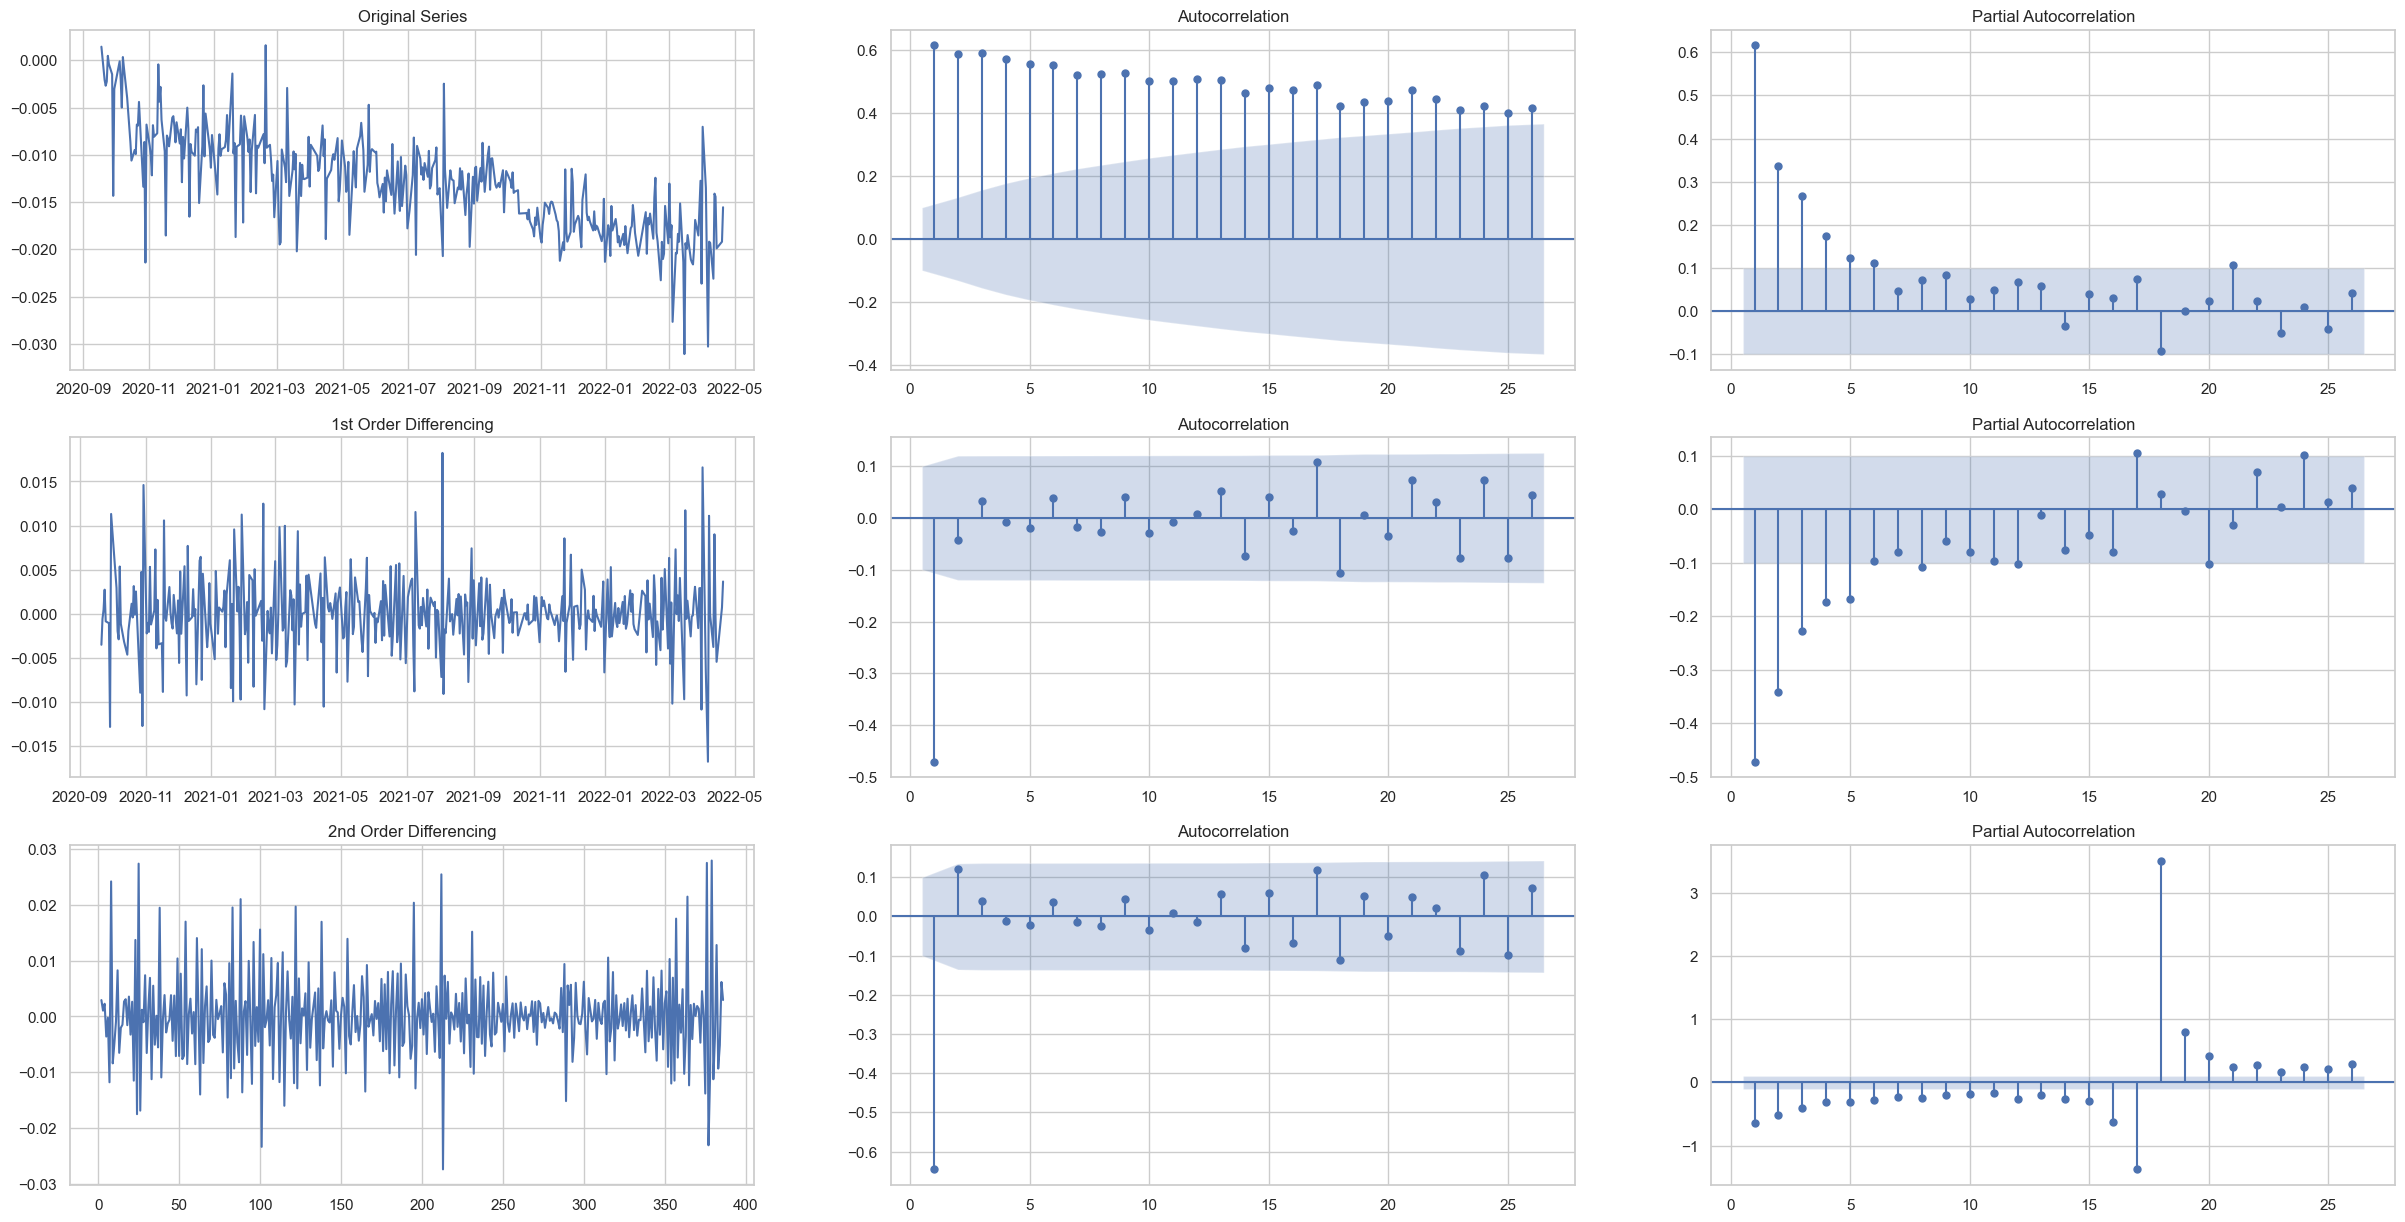

In [186]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(15,9)})
plt.rcParams.update({'font.size':10})
# Import data
df = cum_diff.dropna()
# Original Series
fig, axes = plt.subplots(3, 3,figsize=(30,15))
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df.dropna().values, ax=axes[0, 1],zero=False)
plot_pacf(df.dropna().values, ax=axes[0, 2],zero=False)
# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna().values, ax=axes[1, 1],zero=False)
plot_pacf(df.diff().dropna(), ax=axes[1, 2],zero=False)
# 2nd Differencing
axes[2, 0].plot(df.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna().values, ax=axes[2, 1],zero=False)
plot_pacf(df.diff().diff().dropna(), ax=axes[2, 2],zero=False)
plt.show()

In [187]:
from statsmodels.tsa.stattools import adfuller
print('adfuller value:')
print(adfuller(cum_diff.dropna())[0])
print('adfuller pvalue:')
print(adfuller(cum_diff.dropna())[1])
#1st order diff adfuller
from statsmodels.tsa.stattools import adfuller
print('1st difference adfuller value:')
print(adfuller(cum_diff.diff().dropna())[0])
print('1st difference adfuller pvalue:')
print(adfuller(cum_diff.diff().dropna())[1])

adfuller value:
-1.791472216562695
adfuller pvalue:
0.3847036451519554
1st difference adfuller value:
-9.058435184037064
1st difference adfuller pvalue:
4.632975078643397e-15


In [190]:
#generate latex table for adfuller test
import latextable
from tabulate import tabulate
from texttable import Texttable
display_adf_df=pd.DataFrame([['Cumulative Log Return Difference',adfuller(cum_diff.dropna())[0],adfuller(cum_diff.dropna())[1]],['1st order difference',adfuller(cum_diff.diff().dropna())[0],adfuller(cum_diff.diff().dropna())[1]]],columns=['Series Name','ADF value','ADF p-value']).set_index('Series Name')
display_adf_df.index.name=None
def gen_latex(display_adf_df):
    table = Texttable()
    table.set_cols_align(["c"] * display_adf_df.shape[1])
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(display_adf_df.values)
    print(tabulate(display_adf_df, headers='keys', tablefmt='latex'))

In [194]:
gen_latex(display_adf_df)

\begin{tabular}{lrr}
\hline
                                  &   ADF value &   ADF p-value \\
\hline
 Cumulative Log Return Difference &    -1.79147 &   0.384704    \\
 1st order difference             &    -9.05844 &   4.63298e-15 \\
\hline
\end{tabular}


## Model Examination

In [198]:
name1,name2=('HK.03033', 'HK.03067')
target_series1=log_ret[name1]
target_series2=log_ret[name2]
temp=log_ret[[name1,name2]]
diff=target_series1-target_series2
cum_diff=diff.cumsum()
transcost=3/10000

## Examine the selected pair 3033.HK and 3067.HK

### calculate all possible model

In [215]:
target_result_dic_total={}
(name1,name2)


('HK.03033', 'HK.03067')

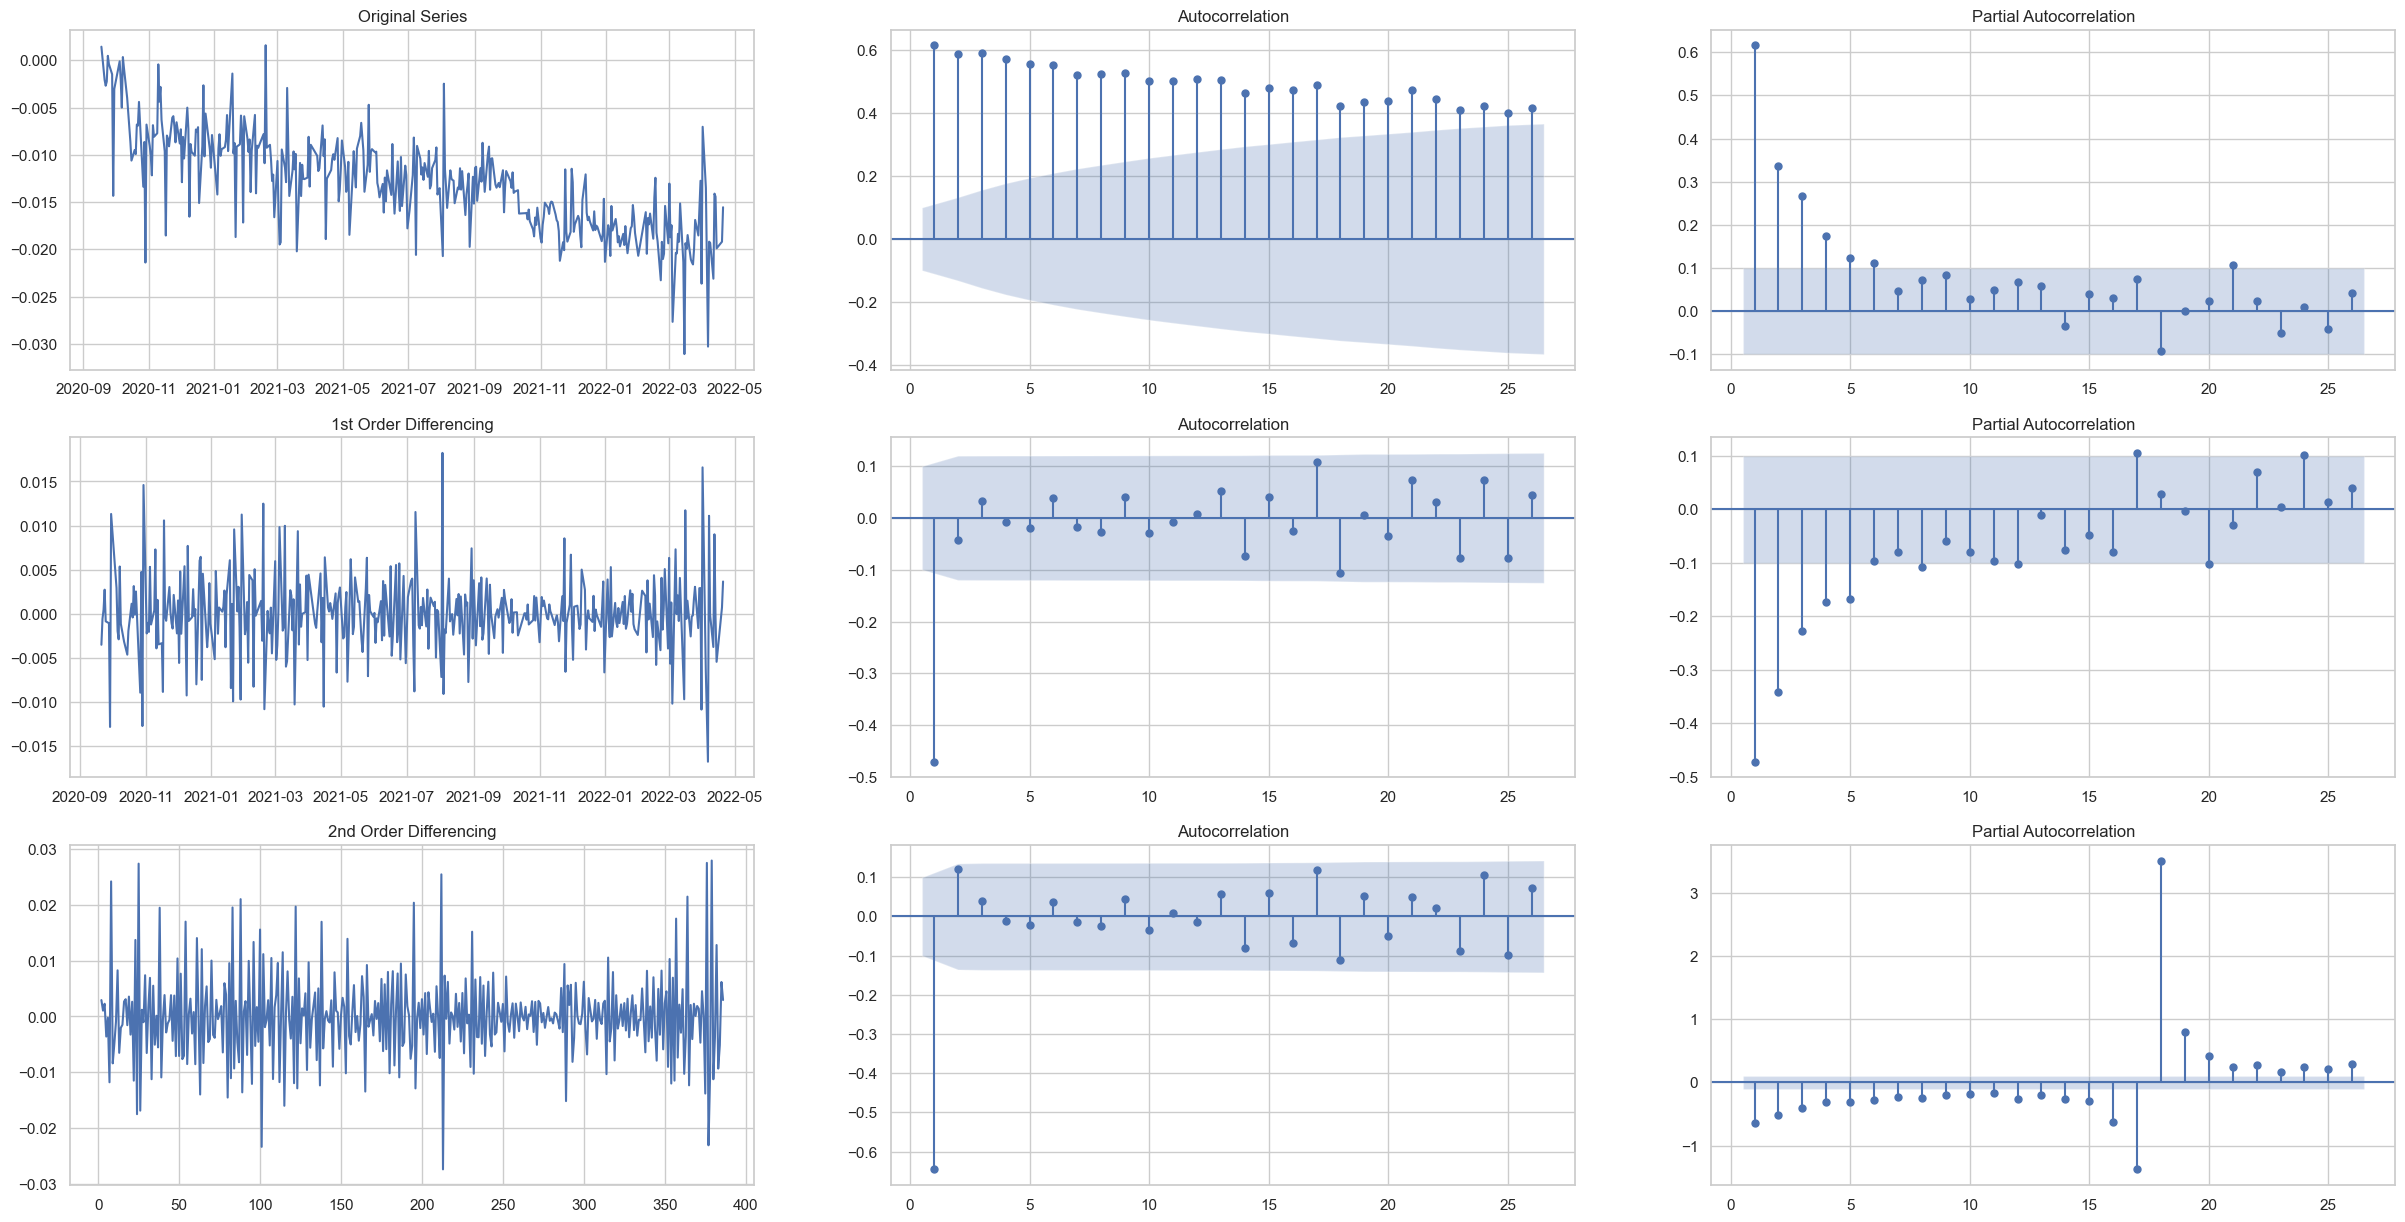

In [217]:
plt.rcParams.update({'figure.figsize':(15,9)})
plt.rcParams.update({'font.size':10})
# Import data
df = cum_diff.dropna()
# Original Series
fig, axes = plt.subplots(3, 3,figsize=(30,15))
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df.dropna().values, ax=axes[0, 1],zero=False)
plot_pacf(df.dropna().values, ax=axes[0, 2],zero=False)
# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna().values, ax=axes[1, 1],zero=False)
plot_pacf(df.diff().dropna(), ax=axes[1, 2],zero=False)
# 2nd Differencing
axes[2, 0].plot(df.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna().values, ax=axes[2, 1],zero=False)
plot_pacf(df.diff().diff().dropna(), ax=axes[2, 2],zero=False)
plt.show()

## Model 1: Null Model-Testing ARIMA (0,0,0)

('HK.03033', 'HK.03067')
(0, 0, 0)


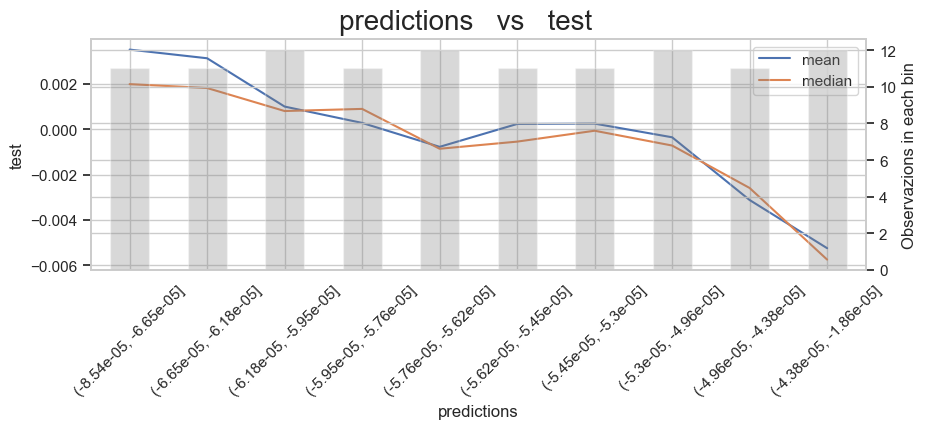

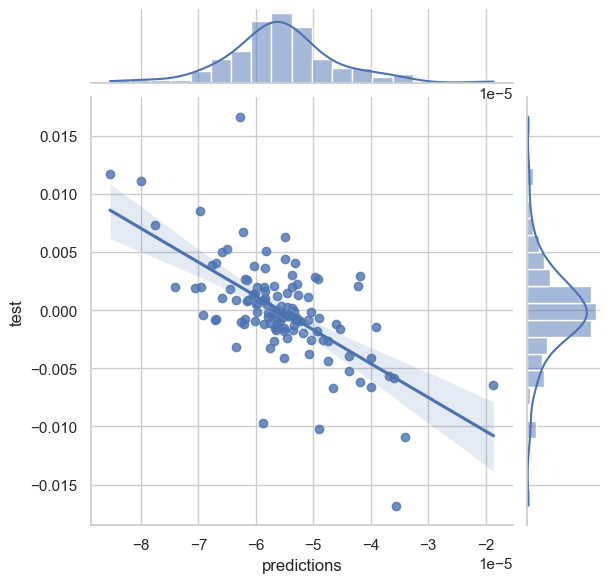

average position: 1.419764935196331


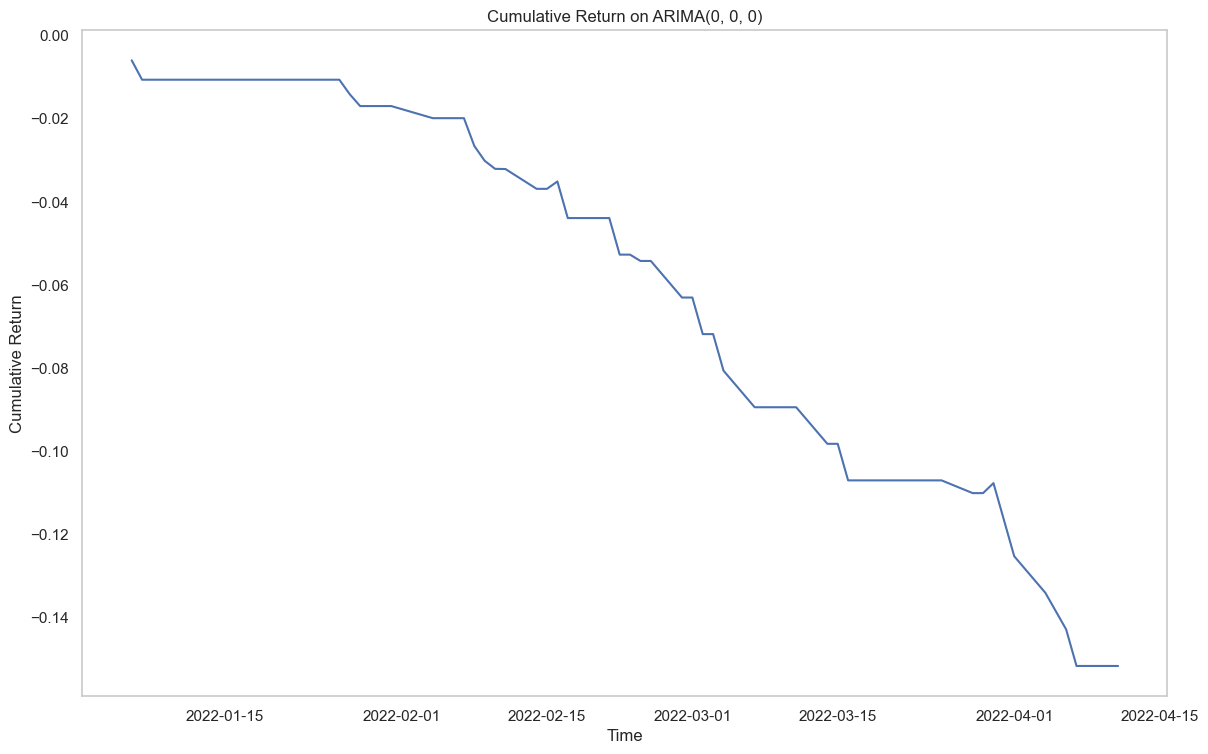

Ljung-Box Test Tatistics


,1,2,3,4,5,6,7,8,9,10
lb_stat,21.606151,24.263677,26.557653,26.888853,26.89069,26.994457,27.647790,28.639084,30.119348,30.765591
lb_pvalue,0.000003,0.000005,0.000007,0.000021,0.00006,0.000145,0.000255,0.000367,0.000419,0.000641


R2 (explained variance): -203087.69
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.97
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: 0


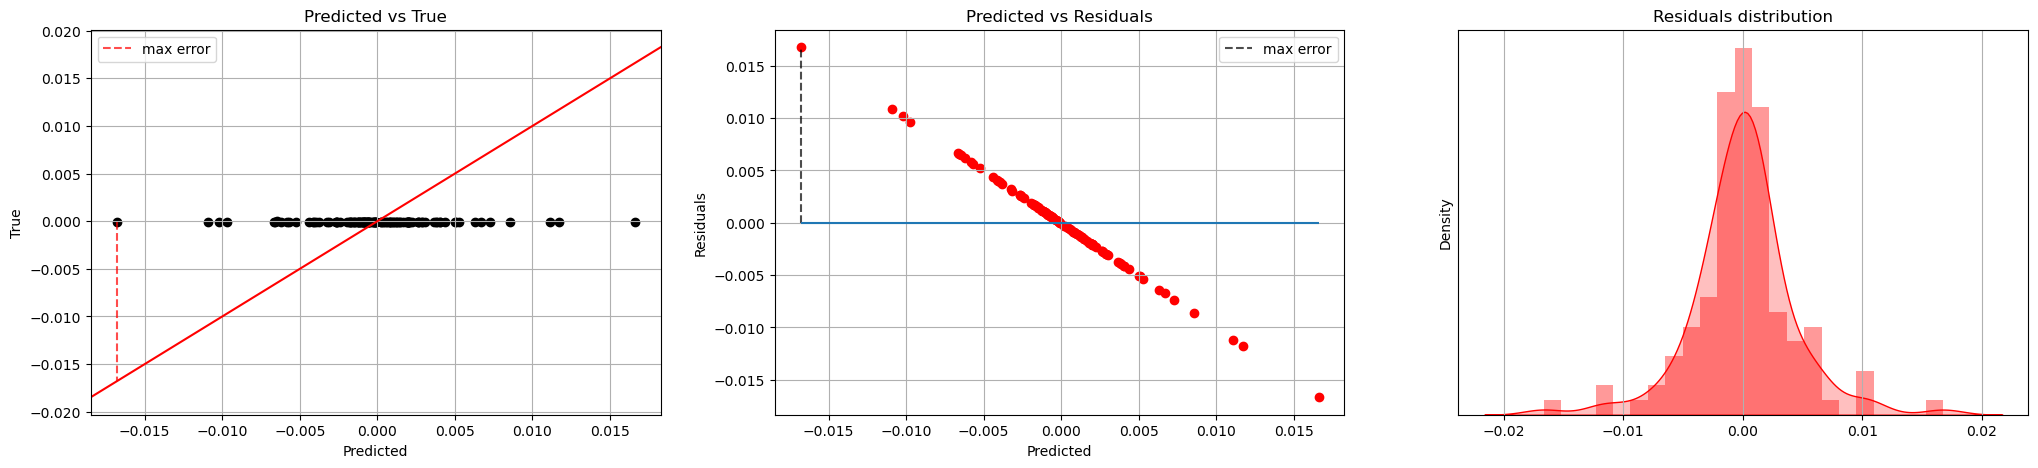

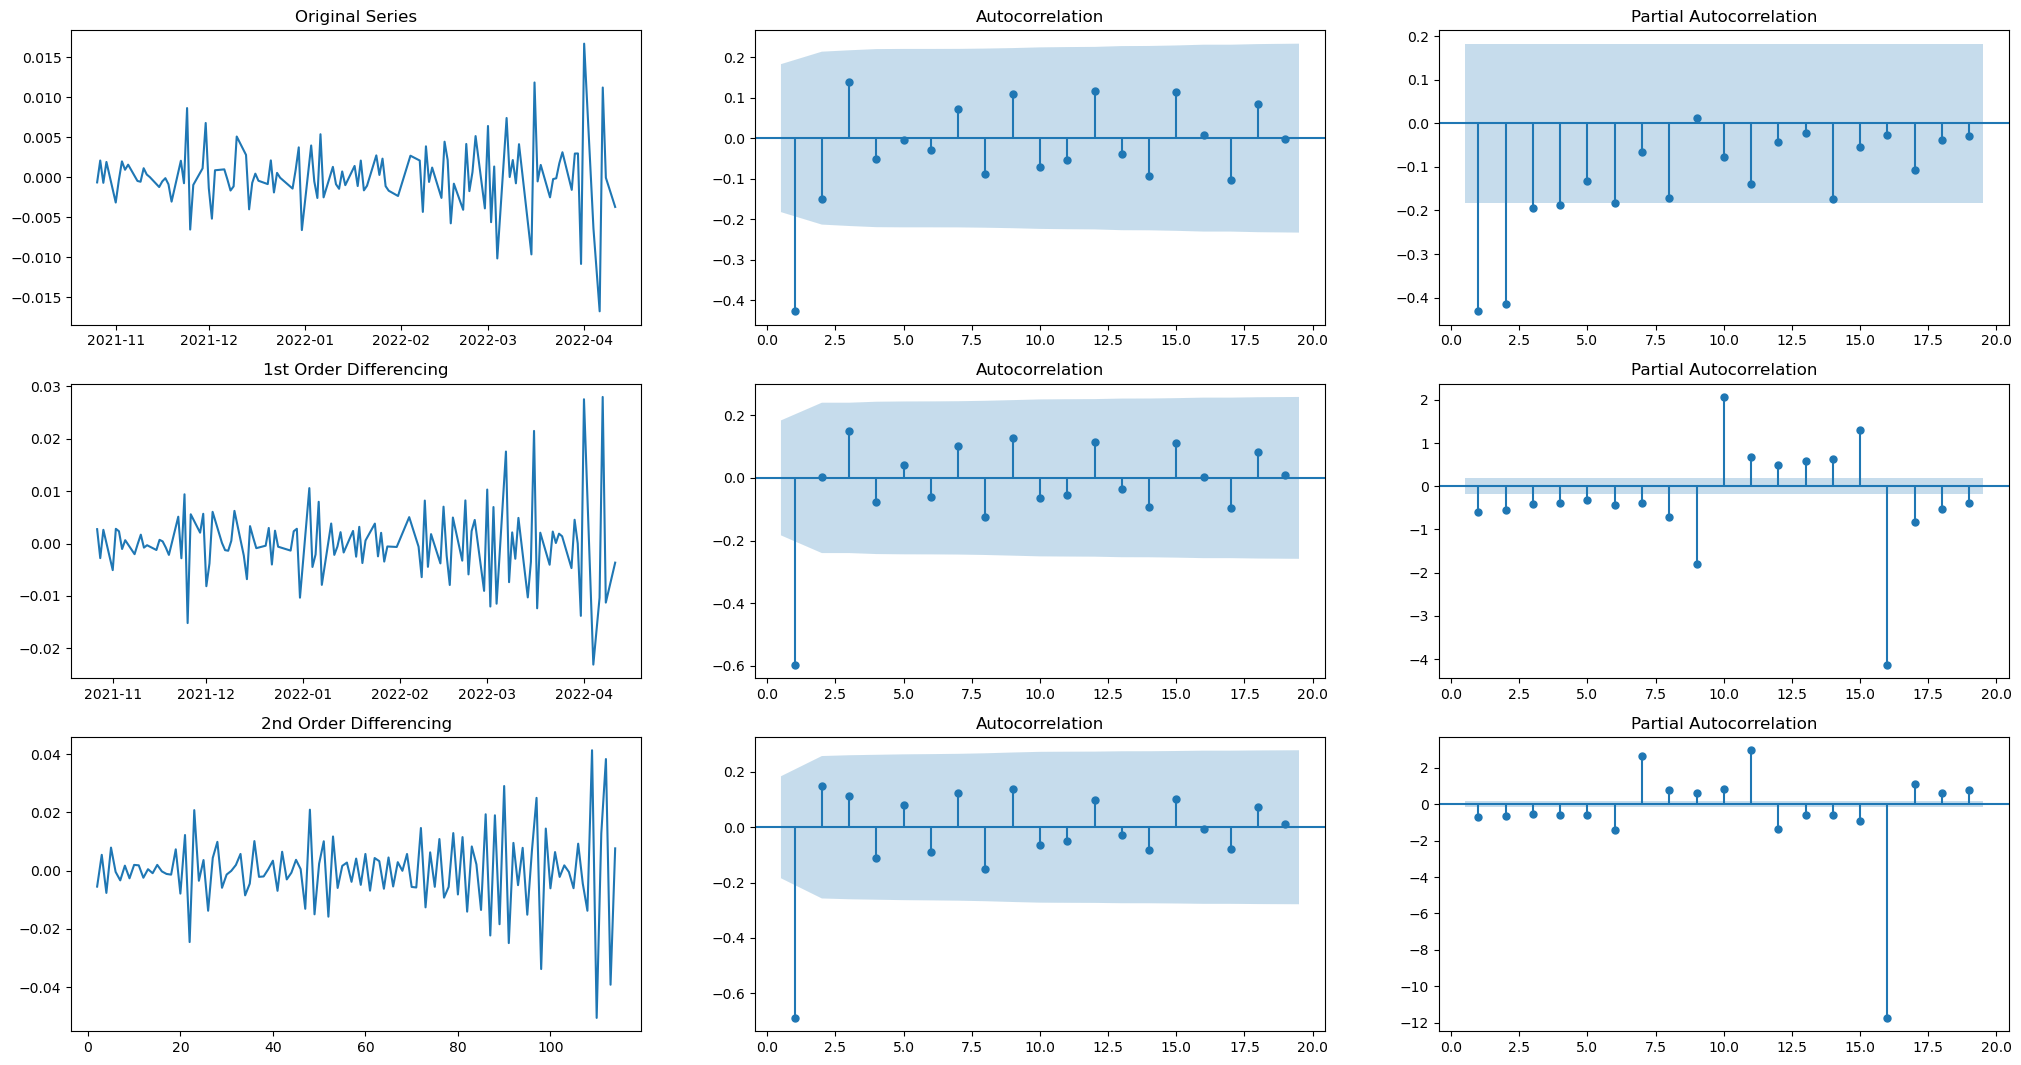

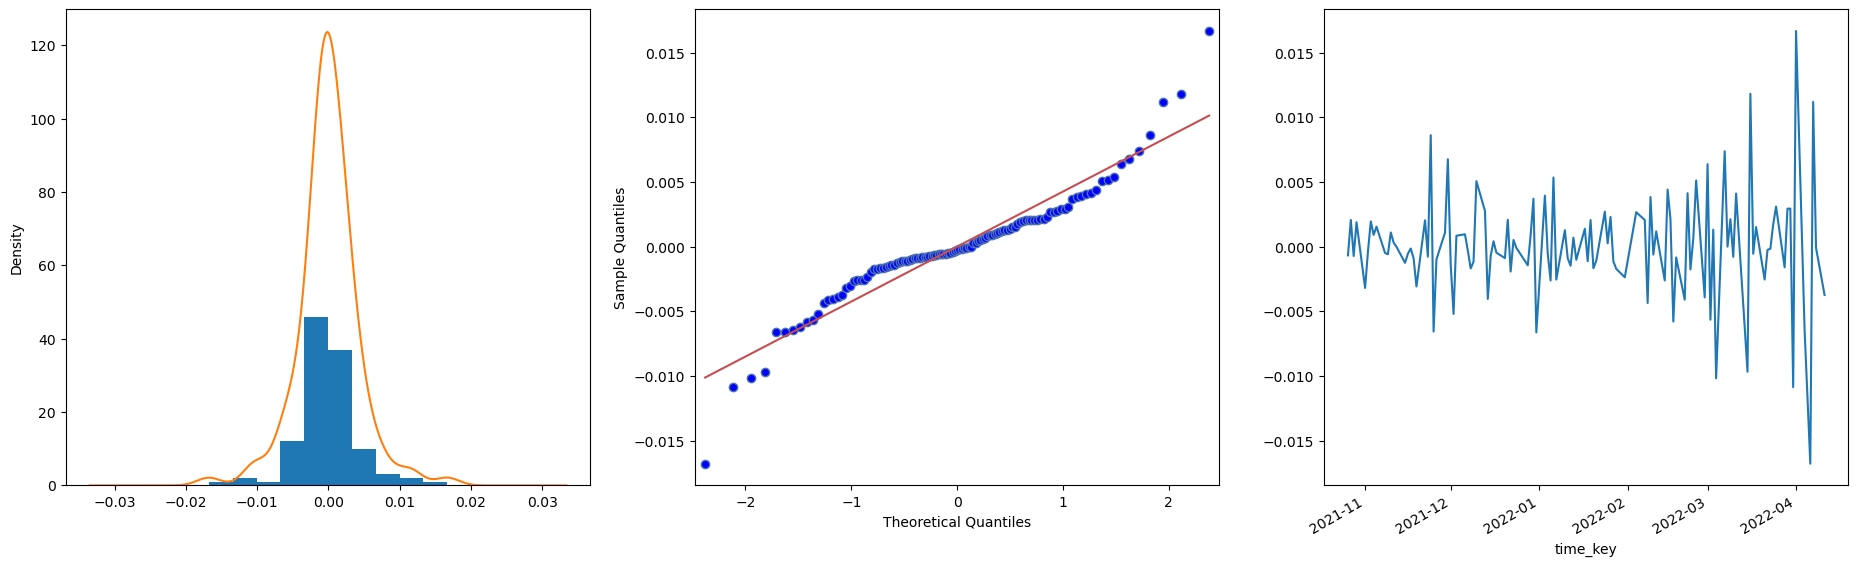

Shapiro-Wilk test result: 0.9263167977333069 /  8.615646038379055e-06


,Parameter
correlation,-0.645
rmse,0.004
ljung-box test(1)-pvalue,0.000
Shapiro-Wilk Test pvalue,0.000
R-squared,-0.003
Annualized Return,-0.337
Sharpe Ratio,-5.781
winrate,0.074


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  382
Model:                     ARMA(0, 0)   Log Likelihood                1526.620
Method:                           css   S.D. of innovations              0.004
Date:                Tue, 03 May 2022   AIC                          -3049.240
Time:                        00:26:08   BIC                          -3041.349
Sample:                             0   HQIC                         -3046.109
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.048e-05      0.000     -0.266      0.790      -0.001       0.000
==============================================================================
"""

In [220]:
params=(0,0,0)
display((name1,name2))
display(params)
period=50
diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
diff=diff.loc[diff.index.year>2016].iloc[:-5]
series= diff.dropna().reset_index(drop=True)
X = series.values
size = int(len(X) * 0.7)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
count=0

print('params: '+str(params))
if params not in target_result_dic.keys():
    for t in range(len(test)):
        count+=1
        print("{:2%}".format(count/len(test)))
        model_fit = ARIMA(history,order=params).fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        clear_output(wait=False)
    print((name1,name2))
    print(params)
    result=pd.DataFrame([predictions,test],index=['predictions','test']).T.dropna()
    result.index=diff.dropna().iloc[size:len(X)].index
    target_result_dic.update({params:result})
else:
    result=target_result_dic[params]
result=target_result_dic[params]
bivariate_plot(result)
series= diff.dropna()
X = series.values
size = int(len(X) * 0.7)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
# result.index=series.iloc[size:len(X)].index
result['position']=(result['predictions']-result['predictions'].rolling(period).mean())/result['predictions'].rolling(period).std()
result['position']=result['position'].apply(lambda x:x if abs(x)>0.7 else 0)
result['position']=result['position'].apply(lambda x:np.sign(x)*2 if abs(x)>2 else x)
# result['position']/=2
transcost=3/10000
result['profit']=result['position']*result['test']-abs(result['position'])*transcost*4
print('average position: '+str(abs(result['position']).replace(0,np.nan).mean()))
stoploss=-1.5*abs(result['profit'].std())
result['profit']=result['profit'].apply(lambda x:stoploss if x<stoploss else x)
result['resid']=result['predictions']-result['test']
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20*0.7,20*0.618*0.7))
plt.title('Cumulative Return on ARIMA'+str(params))
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid()
plt.plot(result['profit'].cumsum().replace(0,np.nan).dropna())
plt.show()
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
print('Ljung-Box Test Tatistics')
resid=result['test']-result['predictions']
pd.options.display.max_columns=None
display(acorr_ljungbox(resid,10,return_df=True).T)
evaluate_regr_model(result.iloc[:,0], result.iloc[:,1], figsize=(25,5))
resid_analysis(resid)
from sklearn.metrics import r2_score
corr=result.corr().iloc[0,1]
rmse=sqrt(mean_squared_error(result.iloc[:,0],result.iloc[:,1]))
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)
r2=r_squared(result.iloc[:,1],result.iloc[:,0])
annual_profit=result['profit'].cumsum().iloc[-1]/len(result)*255
sharpe=annual_profit/result['profit'].replace(0,np.nan).dropna().std()/(255**0.5)
ljung_1=acorr_ljungbox(resid,1,return_df=True).T.iloc[1,0]
winrate=result['profit'].replace(0,np.nan).dropna().apply(lambda x:1 if x>0 else 0).mean()
shapiro_p=shapiro(resid.dropna()).pvalue

display(pd.DataFrame([corr,rmse,ljung_1,shapiro_p,r2,annual_profit,sharpe,winrate],index=['correlation','rmse','ljung-box test(1)-pvalue','Shapiro-Wilk Test pvalue','R-squared','Annualized Return','Sharpe Ratio','winrate'],columns=['Parameter']).apply(lambda x:round(x,3)))
model_fit = ARIMA(X,order=params).fit(disp=0)
model_fit.summary()



In [221]:
diff

time_key
2020-09-18    0.001450
2020-09-21   -0.003533
2020-09-22   -0.000598
2020-09-23    0.000445
2020-09-24    0.002719
                ...   
2022-04-04   -0.006454
2022-04-06   -0.016809
2022-04-07    0.011106
2022-04-08   -0.000134
2022-04-11   -0.003785
Length: 382, dtype: float64

In [622]:
diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)].cumsum()
final_test=diff.loc[diff.index.year>2016].iloc[-5:]


In [618]:
X=pd.Series(X).cumsum().values

In [619]:
model_fit = ARIMA(X,order=(1,1,1)).fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  388
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1671.783
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 26 Apr 2022   AIC                          -3335.567
Time:                        13:00:53   BIC                          -3319.723
Sample:                             1   HQIC                         -3329.285
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.495e-05   5.72e-06     -4.363      0.000   -3.62e-05   -1.37e-05
ar.L1.D.y      0.0661      0.055      1.193      0.233      -0.042       0.175
ma.L1.D.y     -0.9715      0.047    -20.687      0.000      -1.064      -0.879
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           15.1173           +0.0000j           15.1173            0.0000
MA.1            1.0294           +0.0000j            1.0294            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model_fit = ARIMA(X,order=params).fit(disp=0)
model_fit.summary()

In [625]:
predictions=model_fit.forecast(5)[0]

In [624]:
pd.DataFrame([model_fit.forecast(5)[0],final_test]).T

,0,1
0,-0.021159,-0.022131
1,-0.021479,-0.021429
2,-0.021524,-0.017782
3,-0.021550,-0.014961
4,-0.021575,-0.020946


('3033.HK', '3067.HK')


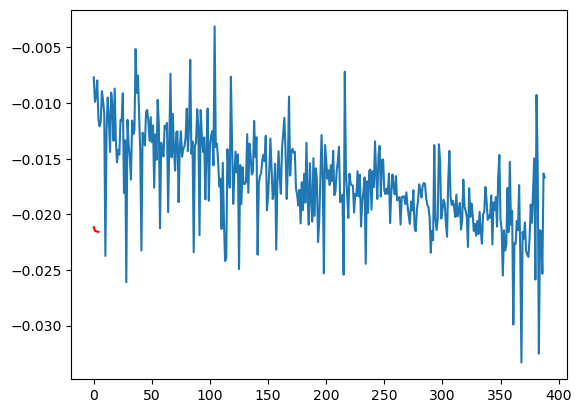

In [629]:
# for t in range(len(test)):
#     count+=1
#     print("{:2%}".format(count/len(test)))
#     model_fit = ARIMA(history,order=params).fit(disp=0)
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat[0])
#     obs = test[t]
#     history.append(obs)
#     clear_output(wait=False)
# evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
print(pairs)
pyplot.plot(X)
pyplot.plot(predictions, color='red')
pyplot.show() 

In [562]:
pd.DataFrame([corr,rmse],index=['correlation','rmse'],columns=['Parameter'])

,Parameter
correlation,-0.612347
rmse,0.004280


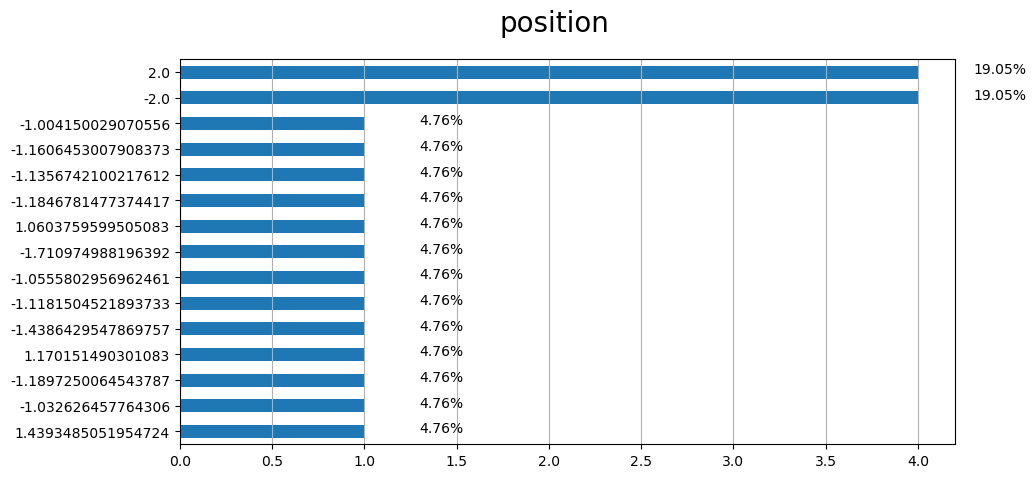

In [548]:
freqdist_plot(result[['position']].replace(0,np.nan).dropna(),'position')

## Model 2: Using Parameter ARIMA (3,0,1)

params: (3, 0, 1)


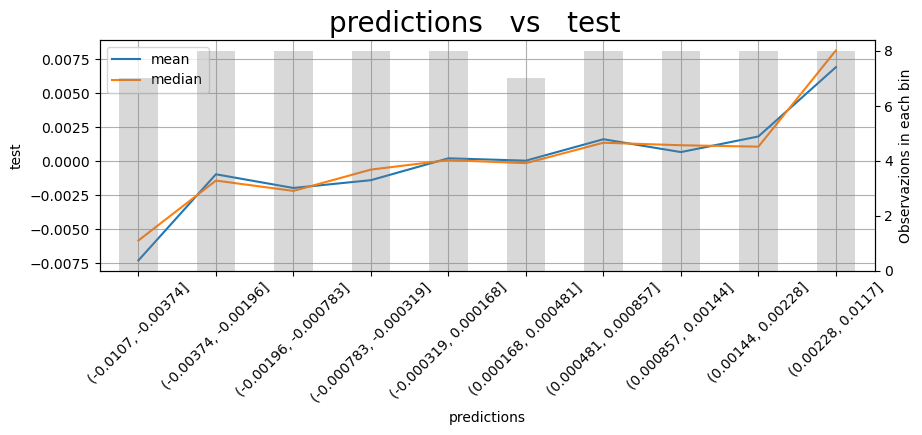

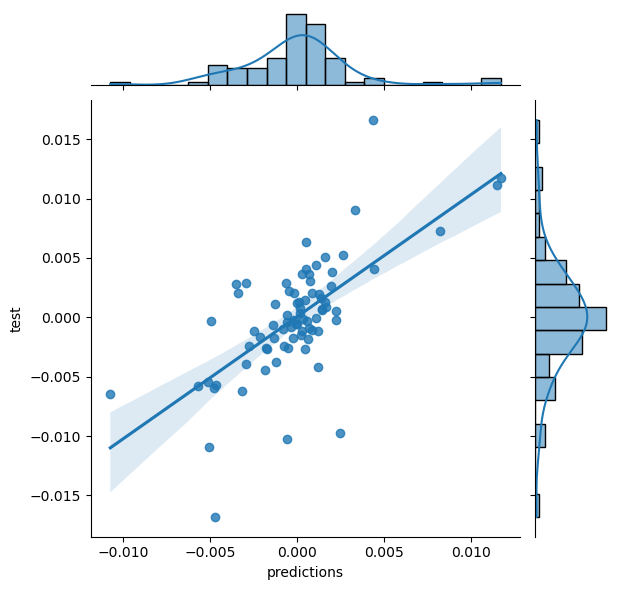

average position: 1.1207738036298873


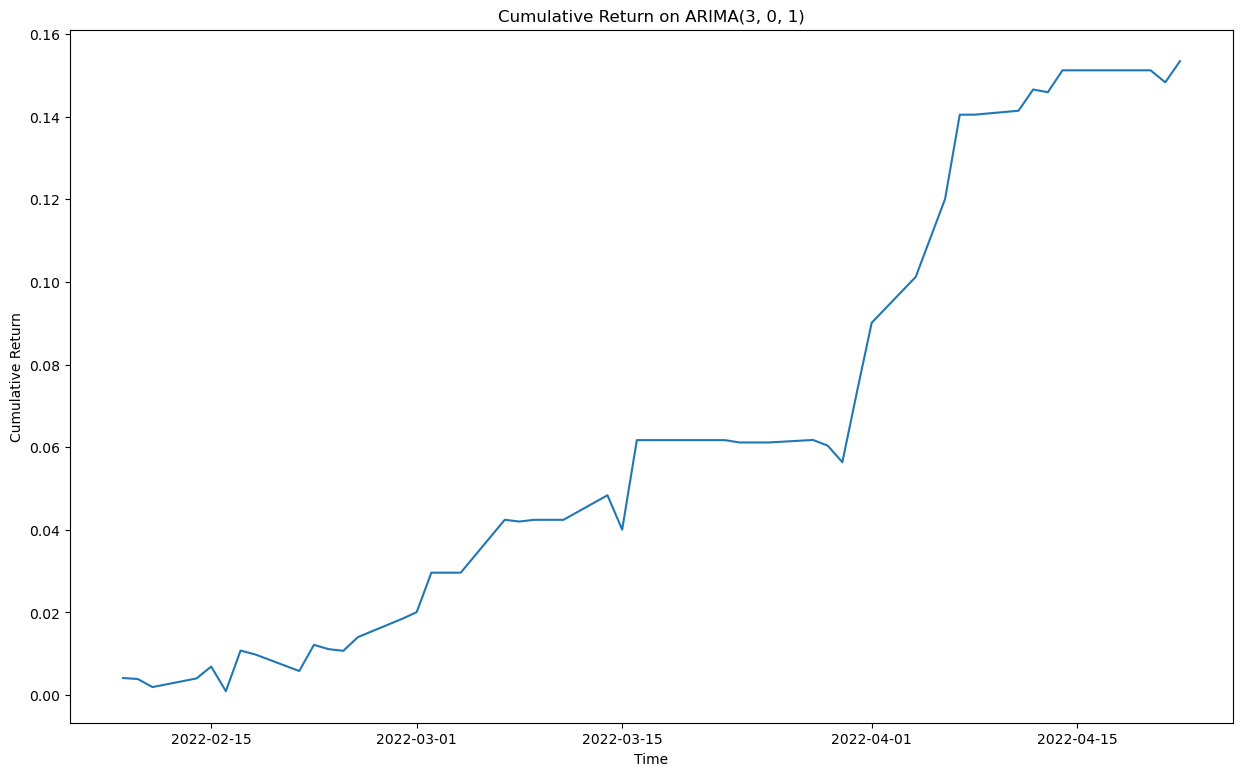

Ljung-Box Test Tatistics


,1,2,3,4,5,6,7,8,9,10
lb_stat,0.108451,1.096536,1.431417,2.787212,3.632203,4.563412,5.617530,6.490622,6.582479,6.688253
lb_pvalue,0.741914,0.577950,0.698187,0.594042,0.603485,0.600896,0.585048,0.592448,0.680499,0.754511


R2 (explained variance): -0.23
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 1.48
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: -0


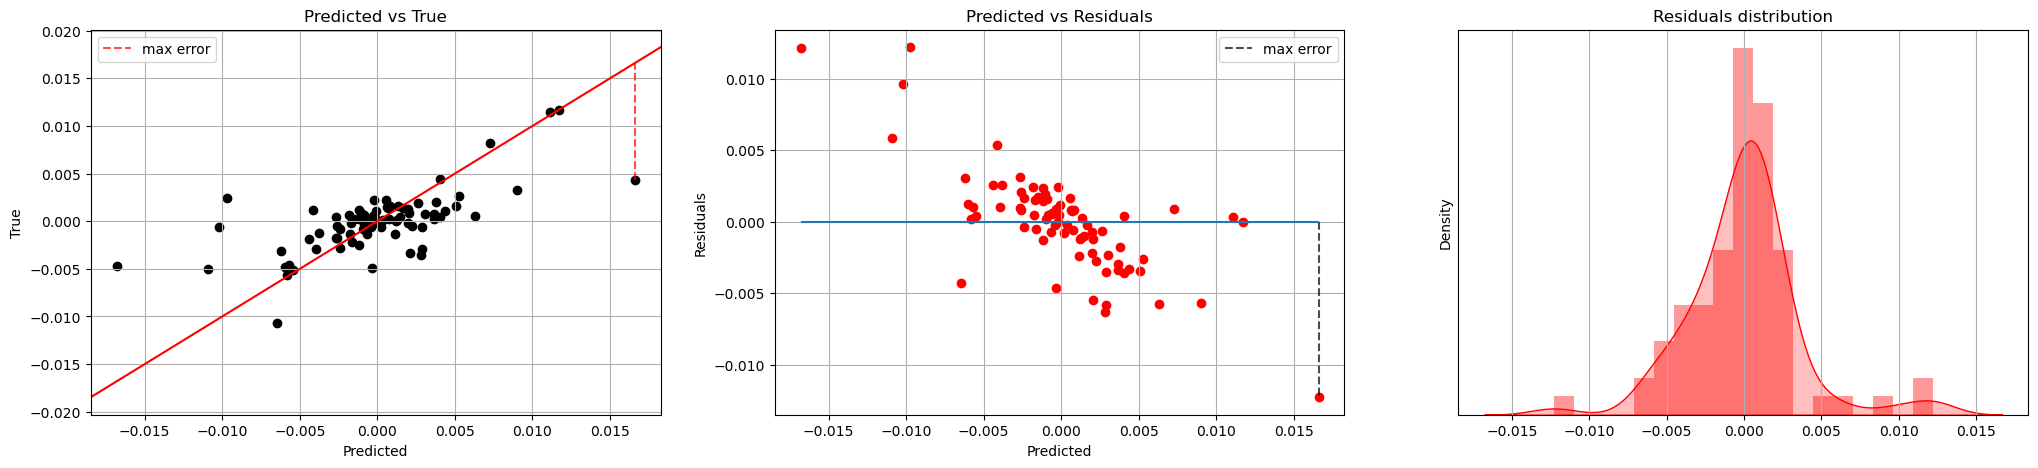

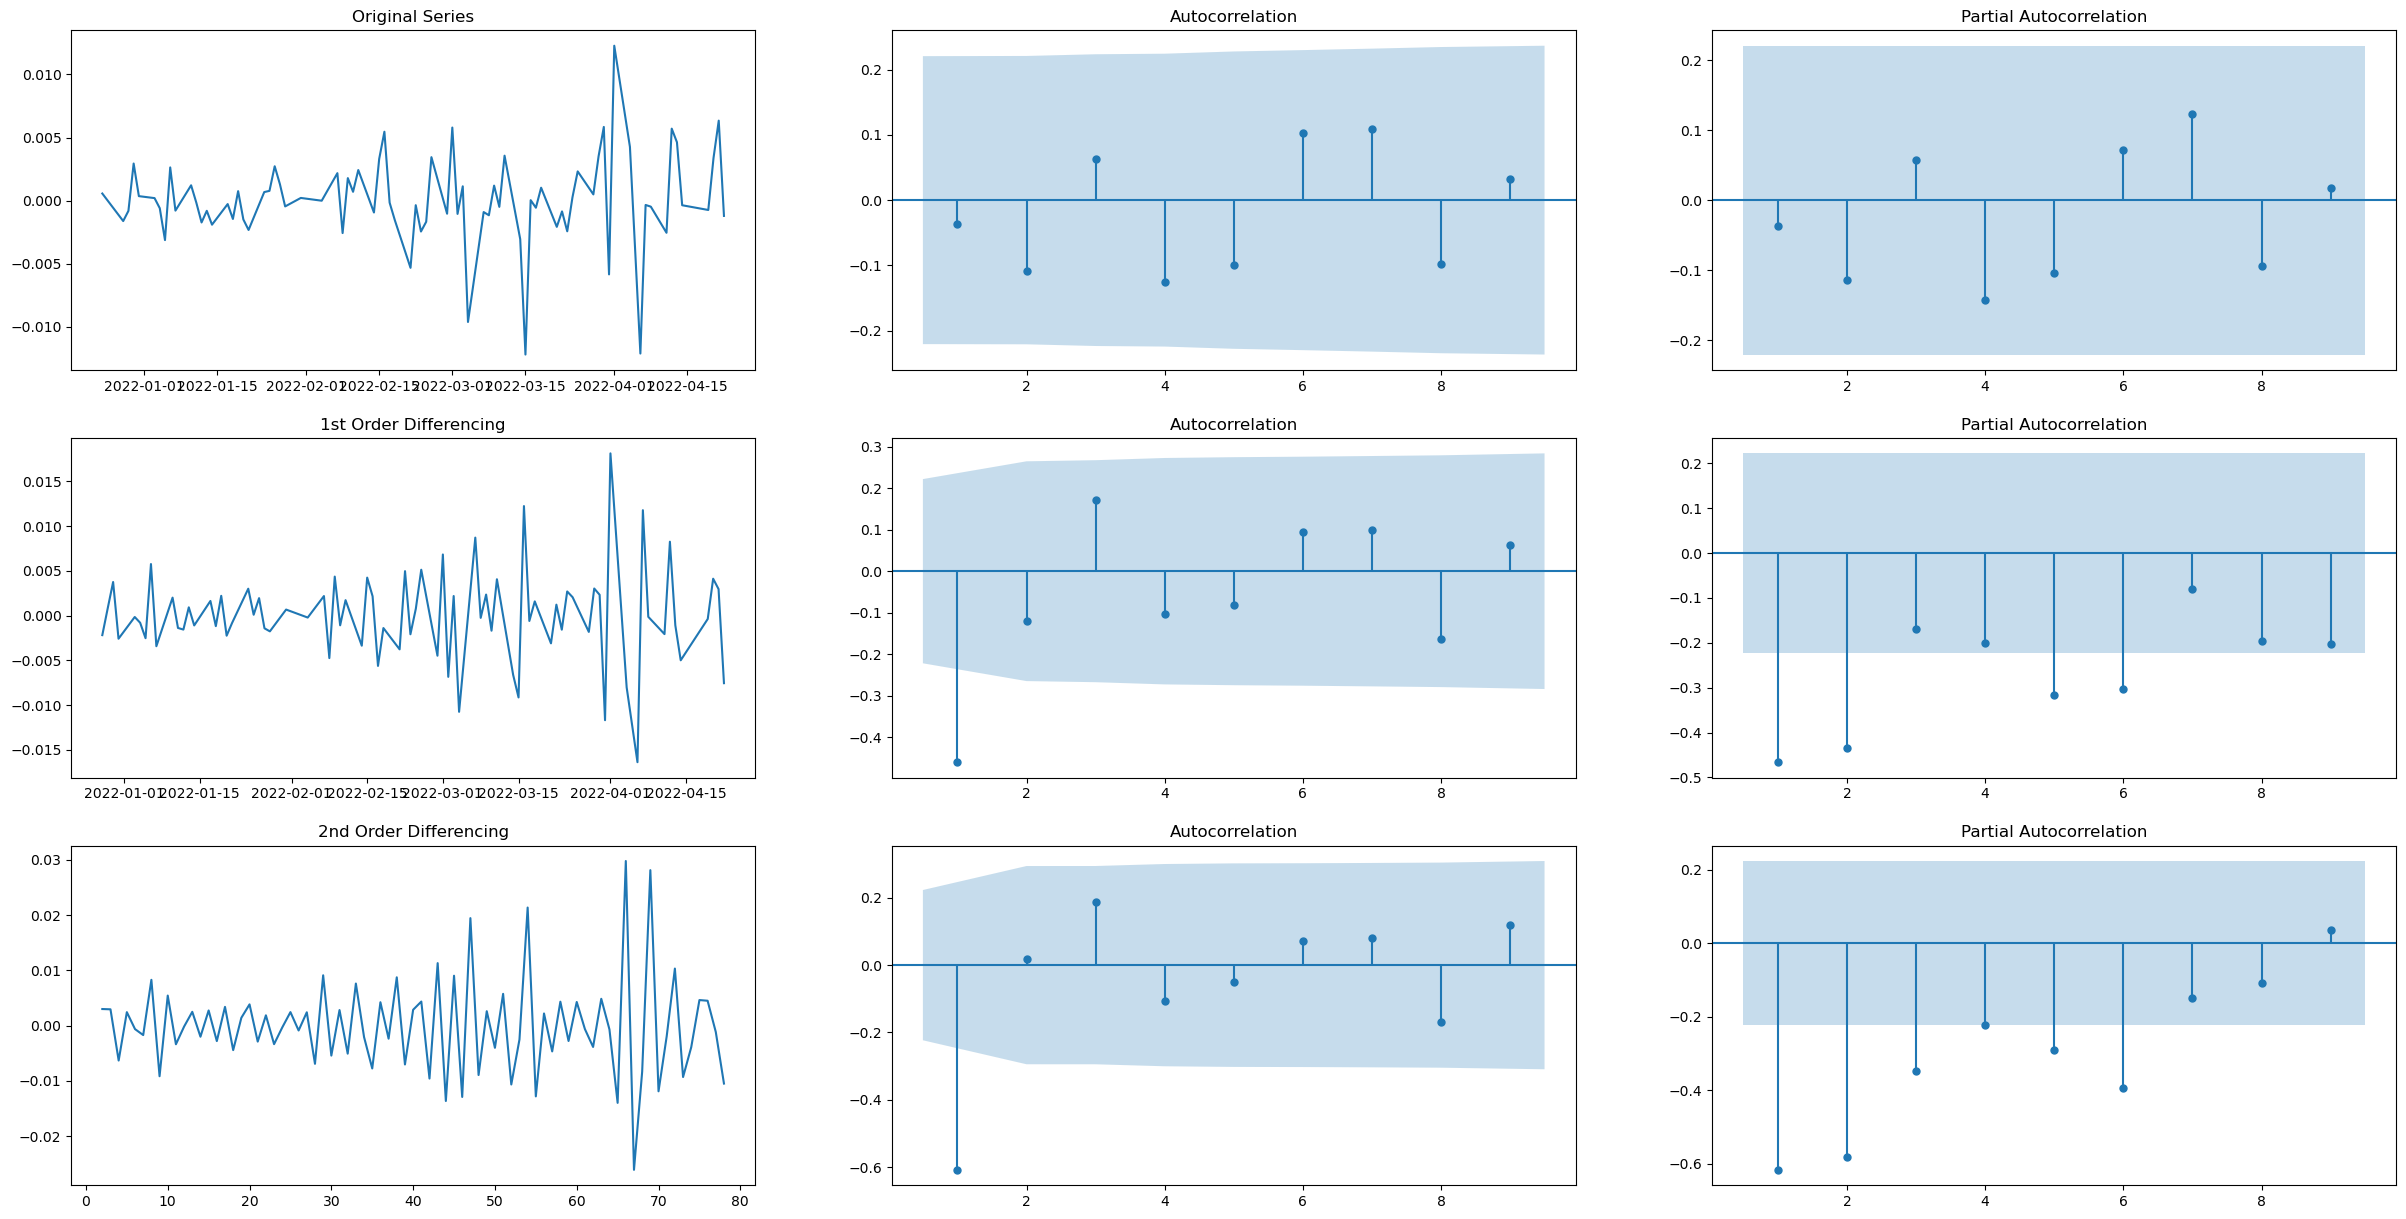

corr:0.6810470769100919
rmse: 0.0035690763711852705


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  394
Model:                     ARMA(3, 1)   Log Likelihood                1691.695
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 26 Apr 2022   AIC                          -3371.390
Time:                        11:27:31   BIC                          -3347.532
Sample:                             0   HQIC                         -3361.937
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.44e-05   3.51e-06     -6.961      0.000   -3.13e-05   -1.75e-05
ar.L1.y        0.0691      0.052      1.316      0.188      -0.034       0.172
ar.L2.y        0.0376      0.053      0.715      0.475      -0.066       0.141
ar.L3.y        0.1351      0.053      2.548      0.011       0.031       0.239
ma.L1.y       -0.9890      0.024    -41.164      0.000      -1.036      -0.942
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7771           -0.0000j            1.7771           -0.0000
AR.2           -1.0278           -1.7628j            2.0406           -0.3340
AR.3           -1.0278           +1.7628j            2.0406            0.3340
MA.1            1.0111           +0.0000j            1.0111            0.0000
-----------------------------------------------------------------------------
"""

In [550]:
# we choose ARIMA(3,0,1) because it seems that approdximately PACF cuts off at 3 and ACF cuts off at 1
params=(3,0,1)
pairs=(name1,name2)
diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
diff=diff.loc[diff.index.year>2017]
series= diff.dropna().reset_index(drop=True)
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
count=0

print('params: '+str(params))
if params not in target_result_dic.keys():
    for t in range(len(test)):
        count+=1
        print("{:2%}".format(count/len(test)))
        model_fit = ARIMA(history,order=params).fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        clear_output(wait=True)
    print(pairs)
    print(params)
    result=pd.DataFrame([predictions,test],index=['predictions','test']).T.dropna()
    result.index=diff.dropna().iloc[size:len(X)].index
    target_result_dic.update({params:result})
else:
    result=target_result_dic[params]
result=target_result_dic[params]
bivariate_plot(result)
series= diff.dropna()
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
result.index=series.iloc[size:len(X)].index
result['position']=(result['predictions']-result['predictions'].rolling(period).mean())/result['predictions'].rolling(period).std()
result['position']=result['position'].apply(lambda x:x if abs(x)>0.3 else 0)
result['position']=result['position'].apply(lambda x:np.sign(x)*2 if abs(x)>2 else x)
# result['position']/=2
result['profit']=result['position']*result['test']-abs(result['position'])*transcost*3

print('average position: '+str(abs(result['position']).replace(0,np.nan).mean()))
stoploss=-1.5*abs(result['profit'].std())
result['profit']=result['profit'].apply(lambda x:stoploss if x<stoploss else x)
result['resid']=result['predictions']-result['test']
plt.title('Cumulative Return on ARIMA'+str(params))
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
# plt.plot(result['profit'].loc[(result.index.month!=7)&(result.index.month!=9)].cumsum().replace(0,np.nan).dropna())
plt.plot(result['profit'].cumsum().replace(0,np.nan).dropna())
plt.show()
print('Ljung-Box Test Tatistics')
resid=result['test']-result['predictions']
pd.options.display.max_columns=None
display(acorr_ljungbox(resid.iloc[:],10,return_df=True).T)
evaluate_regr_model(result.iloc[:,0], result.iloc[:,1], figsize=(25,5))
resid_analysis(resid.iloc[:],lags=10)
print('corr:'+str(result.corr().iloc[0,1]))
print('rmse: '+str(sqrt(mean_squared_error(result.iloc[:,0],result.iloc[:,1]))))
model_fit = ARIMA(X,order=params).fit(disp=0)
model_fit.summary()

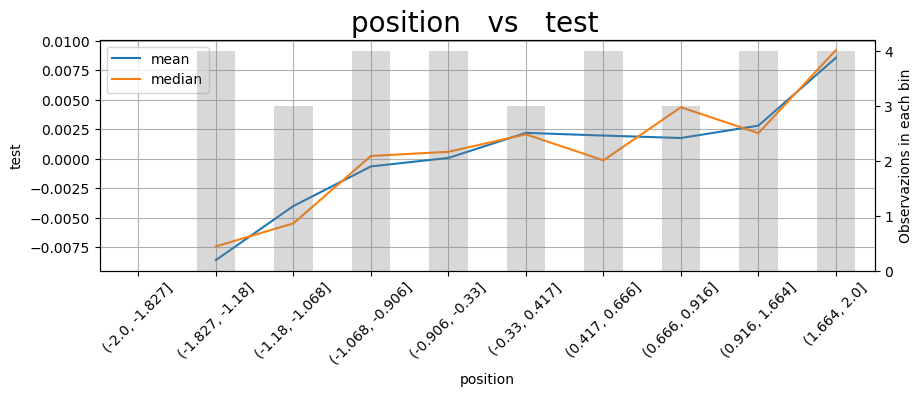

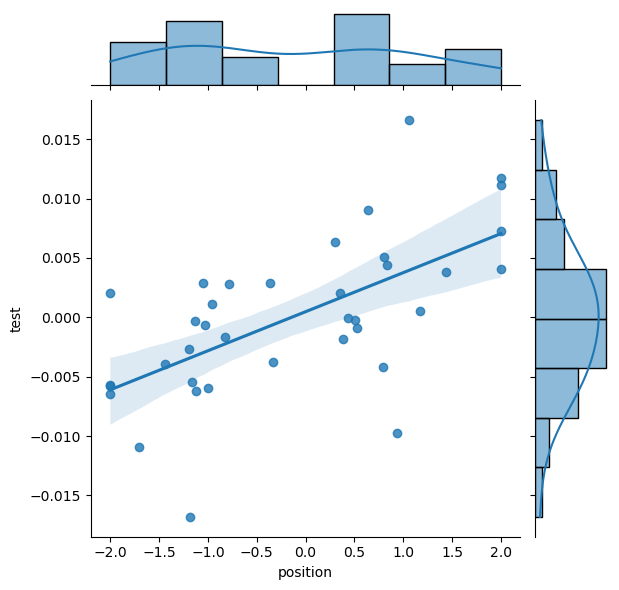

In [554]:
bivariate_plot(result[['position','test']].replace(0,np.nan).dropna())

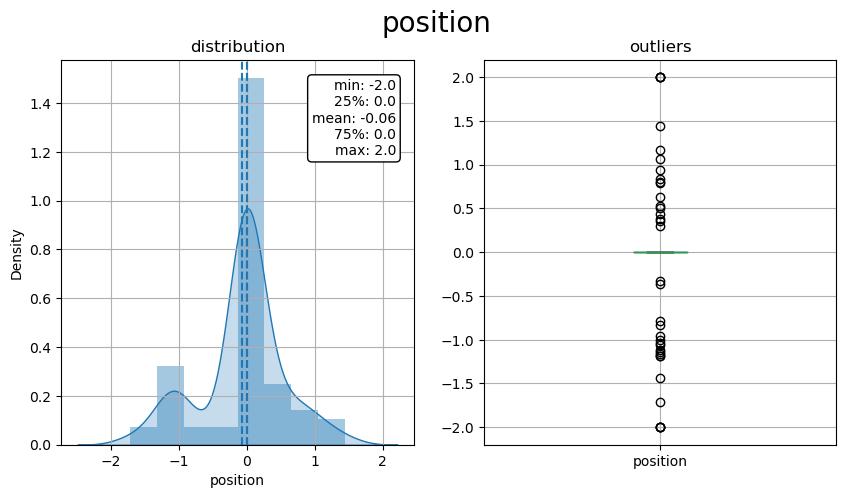

In [552]:
freqdist_plot(result[['position']],'position')

In [443]:
from scipy.stats import shapiro

In [444]:
shapiro(resid.dropna())

ShapiroResult(statistic=0.9048134684562683, pvalue=2.1840120098204352e-05)

In [ ]:
X

In [451]:
model_fit = ARIMA(X[:int(len(X)*3/4)],order=params).fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  295
Model:                     ARMA(1, 1)   Log Likelihood                1268.582
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 26 Apr 2022   AIC                          -2529.165
Time:                        08:53:24   BIC                          -2514.417
Sample:                             0   HQIC                         -2523.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.559e-05   2.37e-06    -10.807      0.000   -3.02e-05   -2.09e-05
ar.L1.y        0.0663      0.060      1.113      0.266      -0.050       0.183
ma.L1.y       -0.9999      0.016    -61.329      0.000      -1.032      -0.968
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           15.0911           +0.0000j           15.0911            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

## Tried parameter (1,0,3) indicated MA not invertible

params: (3, 0, 1)


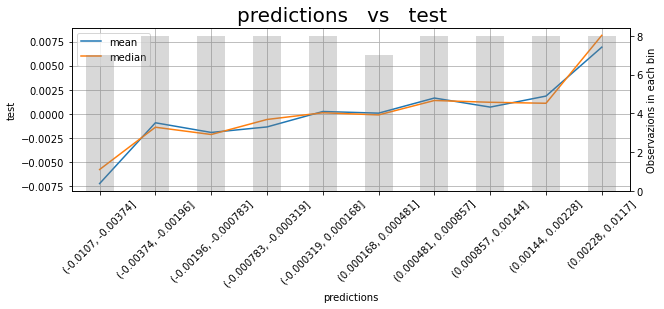

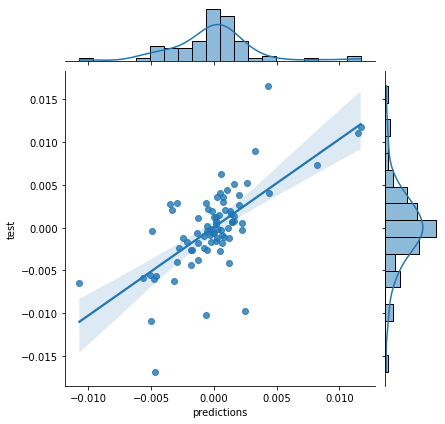

average position: 1.5095582761026347


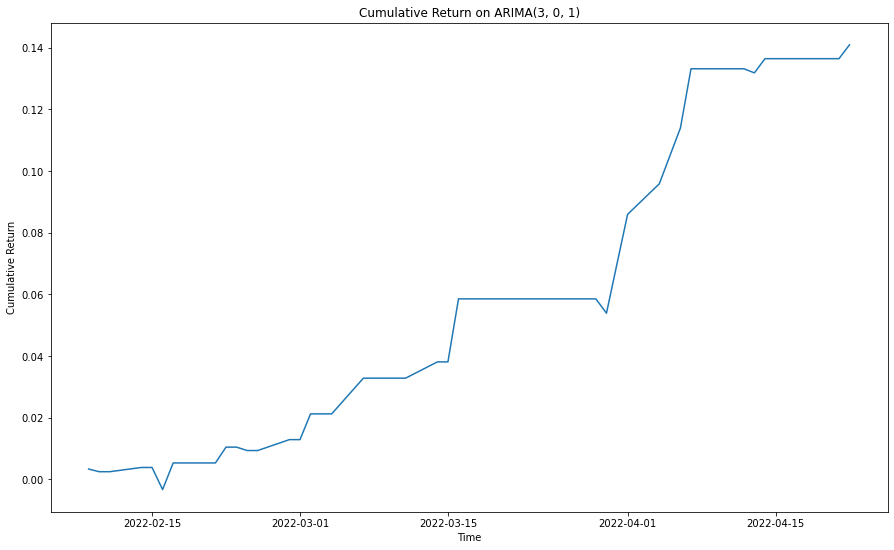

Ljung-Box Test Tatistics


,1,2,3,4,5,6,7,8,9,10
lb_stat,0.108451,1.096536,1.431417,2.787212,3.632203,4.563412,5.617530,6.490622,6.582479,6.688253
lb_pvalue,0.741914,0.577950,0.698187,0.594042,0.603485,0.600896,0.585048,0.592448,0.680499,0.754511


R2 (explained variance): -0.23
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 1.48
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: -0


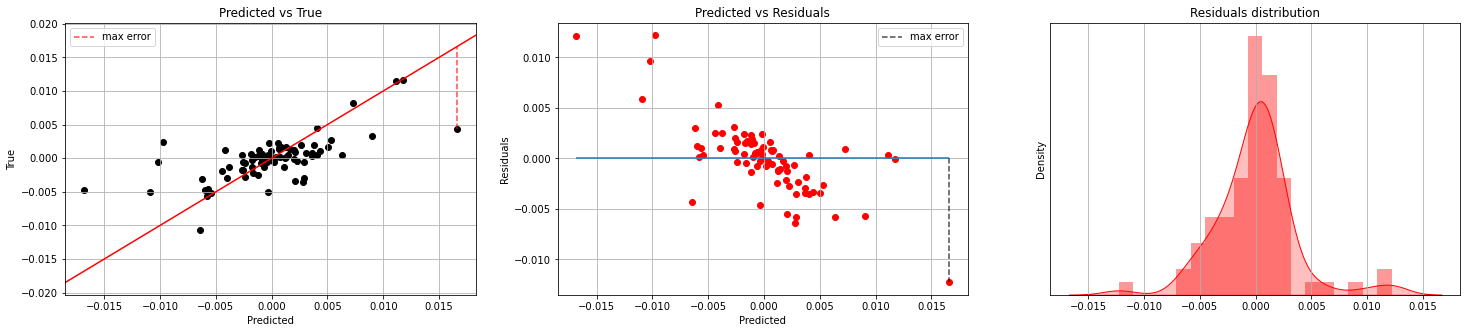

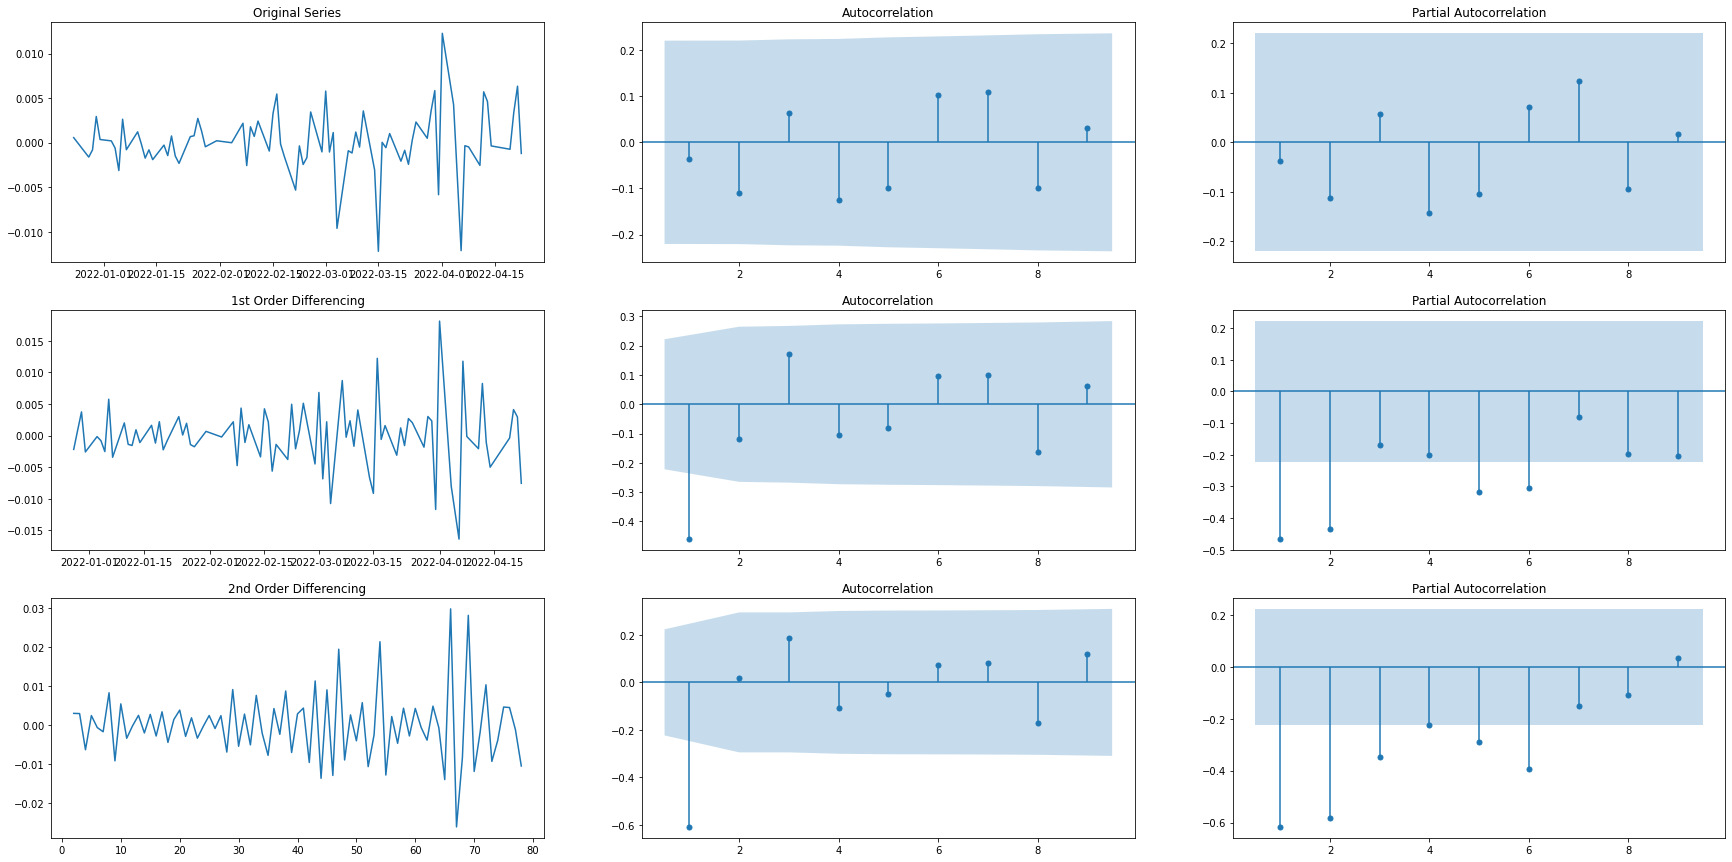

corr:0.6810470769100919
rmse: 0.0035690763711852705


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  394
Model:                     ARMA(3, 1)   Log Likelihood                1691.695
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 26 Apr 2022   AIC                          -3371.390
Time:                        09:26:28   BIC                          -3347.532
Sample:                             0   HQIC                         -3361.937
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.44e-05   3.51e-06     -6.961      0.000   -3.13e-05   -1.75e-05
ar.L1.y        0.0691      0.052      1.316      0.188      -0.034       0.172
ar.L2.y        0.0376      0.053      0.715      0.475      -0.066       0.141
ar.L3.y        0.1351      0.053      2.548      0.011       0.031       0.239
ma.L1.y       -0.9890      0.024    -41.164      0.000      -1.036      -0.942
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7771           -0.0000j            1.7771           -0.0000
AR.2           -1.0278           -1.7628j            2.0406           -0.3340
AR.3           -1.0278           +1.7628j            2.0406            0.3340
MA.1            1.0111           +0.0000j            1.0111            0.0000
-----------------------------------------------------------------------------
"""

In [465]:
# we choose ARIMA(3,0,1) because it seems that approdximately PACF cuts off at 3 and ACF cuts off at 1
params=(3,0,1)


diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
diff=diff.loc[diff.index.year>2017]
series= diff.dropna().reset_index(drop=True)
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
count=0

print('params: '+str(params))
if params not in target_result_dic.keys():
    for t in range(len(test)):
        count+=1
        print("{:2%}".format(count/len(test)))
        model_fit = ARIMA(history,order=params).fit(disp=0)
        yhat = model_fit.forecast()[0] 
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        history.pop(9)
        clear_output(wait=False)
    print(pairs)
    print(params)
    result=pd.DataFrame([predictions,test],index=['predictions','test']).T.dropna()
    result.index=diff.dropna().iloc[size:len(X)].index
    target_result_dic.update({params:result})
else:
    result=target_result_dic[params]
result=target_result_dic[params]
bivariate_plot(result)
series= diff.dropna()
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
result.index=series.iloc[size:len(X)].index
result['position']=(result['predictions']-result['predictions'].rolling(period).mean())/result['predictions'].rolling(period).std()
result['position']=result['position'].apply(lambda x:x if abs(x)>1 else 0)
result['position']=result['position'].apply(lambda x:np.sign(x)*2 if abs(x)>2 else x)
# result['position']/=2
result['profit']=result['position']*result['test']-abs(result['position'])*transcost*5

print('average position: '+str(abs(result['position']).replace(0,np.nan).mean()))
stoploss=-1.5*abs(result['profit'].std())
result['profit']=result['profit'].apply(lambda x:stoploss if x<stoploss else x)
result['resid']=result['predictions']-result['test']
plt.title('Cumulative Return on ARIMA'+str(params))
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
# plt.plot(result['profit'].loc[(result.index.month!=7)&(result.index.month!=9)].cumsum().replace(0,np.nan).dropna())
plt.plot(result['profit'].cumsum().replace(0,np.nan).dropna())
plt.show()
print('Ljung-Box Test Tatistics')
resid=result['test']-result['predictions']
pd.options.display.max_columns=None
display(acorr_ljungbox(resid.iloc[:],10,return_df=True).T)
evaluate_regr_model(result.iloc[:,0], result.iloc[:,1], figsize=(25,5))
resid_analysis(resid.iloc[:],lags=20)
print('corr:'+str(result.corr().iloc[0,1]))
print('rmse: '+str(sqrt(mean_squared_error(result.iloc[:,0],result.iloc[:,1]))))
model_fit = ARIMA(X,order=params).fit(disp=0)
model_fit.summary()
shapiro(resid.dropna())


In [480]:
shapiro(np.random.normal(0,1,100))

ShapiroResult(statistic=0.9886459708213806, pvalue=0.5569856762886047)

ShapiroResult(statistic=0.8992505073547363, pvalue=1.2686214176937938e-05)

ShapiroResult(statistic=0.8992505073547363, pvalue=1.2686187801591586e-05)

In [461]:
corr_dic={}
rmse_dic={}

In [471]:
corr_dic[(4,1)]

0.6601117855885984

In [472]:
pd.DataFrame(rmse_dic,index=[0]).T

0
4 3  0.003709
  2  0.003614
  1  0.003660
3 3  0.003631
  2  0.003558
  1  0.003569
2 2  0.003568
  1  0.003621
1 2  0.003552
  1  0.003547

'3033.HK'

In [65]:
diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year>2017)&(diff.index.date<pd.to_datetime('2023-07-01',format="%Y-%m-%d"))]

diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
df = diff.dropna()
model_1 = pm.auto_arima(df.dropna(), start_p=10, start_q=10,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=600, max_q=600, # maximum p and q
                    m=1,              # frequency of series
                    d=None,           # let model determine 'd'
                    seasonal=False,   # No Seasonality
                    trace=True,
                    information_criterion='aic',
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)
model_1.get_params()['order']
model_1.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2601.793, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2757.621, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2772.846, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-2785.072, Time=0.43 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-2783.115, Time=0.43 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-2780.813, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2686.422, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2758.718, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2768.848, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2782.765, Time=0.46 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-2778.829, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2716.221, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2769.996, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2770.752, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2780.191, Time=0.55

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  345
Model:               SARIMAX(0, 0, 3)   Log Likelihood                1396.536
Date:                Mon, 02 May 2022   AIC                          -2785.072
Time:                        21:39:57   BIC                          -2769.698
Sample:                             0   HQIC                         -2778.949
                                - 345                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8587      0.048    -17.846      0.000      -0.953      -0.764
ma.L2         -0.0427      0.065     -0.655      0.512      -0.171       0.085
ma.L3         -0.0440      0.048     -0.917      0.359      -0.138       0.050
sigma2      1.769e-05   9.94e-07     17.805      0.000    1.57e-05    1.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                81.23
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.75
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model 3: Testing ARIMA(0,0,1) chosen by AIC criteria

params: (0, 0, 1)


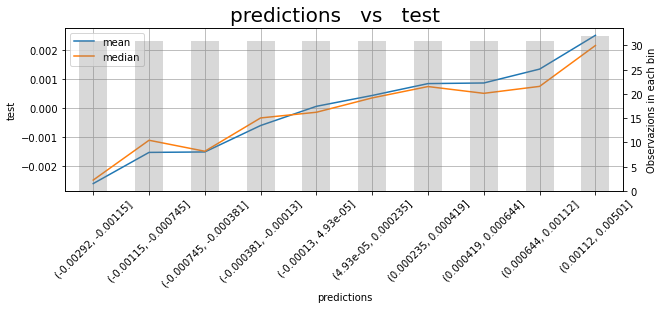

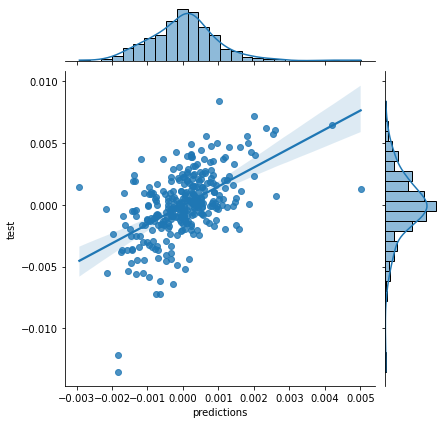

average position: 1.4917458108292587


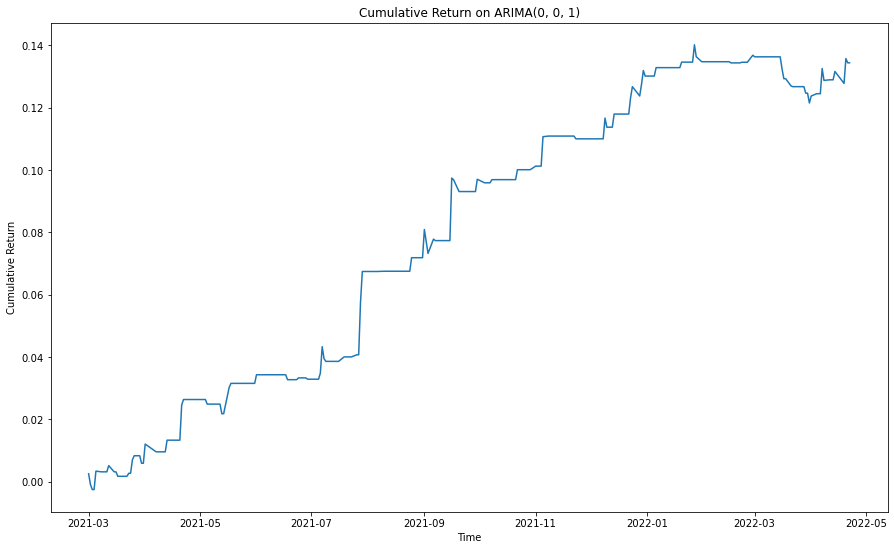

Ljung-Box Test Tatistics


,1,2,3,4,5
lb_stat,8.197284,9.155285,11.466857,11.673458,13.076221
lb_pvalue,0.004195,0.010279,0.009452,0.019952,0.022675


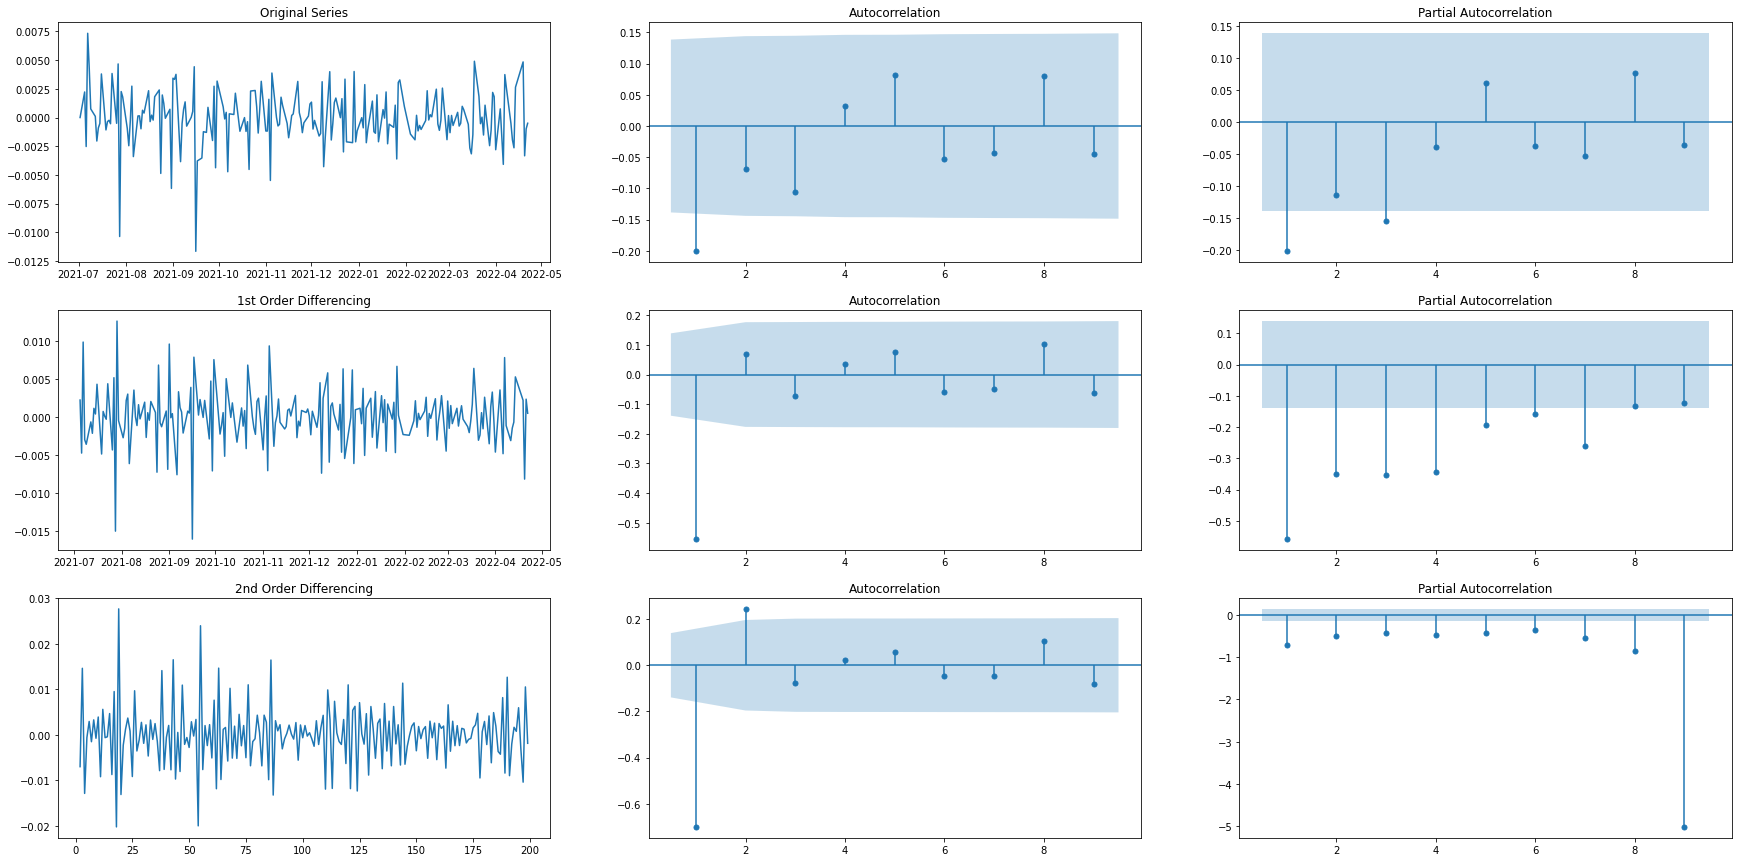

corr:0.5425009824479394
rmse: 0.0023272461535120957


In [349]:

params=(0,0,1)

diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[diff.index.year>2017]
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
df = diff.dropna()
model_1 = pm.auto_arima(df.dropna(), start_p=0, start_q=0,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=60, max_q=60, # maximum p and q
                    m=1,              # frequency of series
                    d=None,           # let model determine 'd'
                    seasonal=False,   # No Seasonality
                    trace=False,
                    information_criterion='aic',
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=False)
# print(model.summary())
params=model_1.get_params()['order']


diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[diff.index.year>2017]
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
series= diff.dropna().reset_index(drop=True)
X = series.values
size = int(len(X) * 0.7)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
count=0

print('params: '+str(params))
if params not in target_result_dic.keys():
    for t in range(len(test)):
        count+=1
        print("{:2%}".format(count/len(test)))
        model_fit = ARIMA(history,order=params).fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        clear_output(wait=False)
    print(pairs)
    print(params)
    result=pd.DataFrame([predictions,test],index=['predictions','test']).T.dropna()
    result.index=diff.dropna().iloc[size:len(X)].index
    target_result_dic.update({params:result})
else:
    result=target_result_dic[params]
result=target_result_dic[params]
bivariate_plot(result)
series= diff.dropna()
X = series.values
size = int(len(X) * 0.7)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
result.index=series.iloc[size:len(X)].index
result['position']=(result['predictions']-result['predictions'].rolling(period).mean())/result['predictions'].rolling(period).std()
result['position']=result['position'].apply(lambda x:x if abs(x)>1 else 0)
result['position']=result['position'].apply(lambda x:np.sign(x)*2 if abs(x)>2 else x)
# result['position']/=2
result['profit']=result['position']*result['test']-abs(result['position'])*transcost*5

print('average position: '+str(abs(result['position']).replace(0,np.nan).mean()))
stoploss=-1.5*abs(result['profit'].std())
result['profit']=result['profit'].apply(lambda x:stoploss if x<stoploss else x)
result['resid']=result['predictions']-result['test']
plt.title('Cumulative Return on ARIMA'+str(params))
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.plot(result['profit'].cumsum().replace(0,np.nan).dropna())
plt.show()
print('Ljung-Box Test Tatistics')
resid=result['test']-result['predictions']
pd.options.display.max_columns=None
display(acorr_ljungbox(resid.iloc[-200:],5,return_df=True).T)
resid_analysis(resid.iloc[-200:],lags=10)
print('corr:'+str(result.corr().iloc[0,1]))
print('rmse: '+str(sqrt(mean_squared_error(result.iloc[:,0],result.iloc[:,1]))))


## Model 4: Try to deviate from optimal model observed by auto-arima

In [ ]:
# we choose ARIMA(3,0,1) because it seems that approdximately PACF cuts off at 3 and ACF cuts off at 1
params=(2,0,1)

diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
diff=diff.loc[diff.index.year>2017]
series= diff.dropna().reset_index(drop=True)
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
count=0

print('params: '+str(params))
if params not in target_result_dic.keys():
    for t in range(len(test)):
        count+=1
        print("{:2%}".format(count/len(test)))
        model_fit = ARIMA(history,order=params).fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        clear_output(wait=False)
    print(pairs)
    print(params)
    result=pd.DataFrame([predictions,test],index=['predictions','test']).T.dropna()
    result.index=diff.dropna().iloc[size:len(X)].index
    target_result_dic.update({params:result})
else:
    result=target_result_dic[params]
result=target_result_dic[params]
bivariate_plot(result)
series= diff.dropna()
X = series.values
size = int(len(X) * 0.8)
if size<100:
    size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
result.index=series.iloc[size:len(X)].index
result['position']=(result['predictions']-result['predictions'].rolling(period).mean())/result['predictions'].rolling(period).std()
result['position']=result['position'].apply(lambda x:x if abs(x)>1 else 0)
result['position']=result['position'].apply(lambda x:np.sign(x)*2 if abs(x)>2 else x)
# result['position']/=2
result['profit']=result['position']*result['test']-abs(result['position'])*transcost*5

print('average position: '+str(abs(result['position']).replace(0,np.nan).mean()))
stoploss=-1.5*abs(result['profit'].std())
result['profit']=result['profit'].apply(lambda x:stoploss if x<stoploss else x)
result['resid']=result['predictions']-result['test']
plt.title('Cumulative Return on ARIMA'+str(params))
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
# plt.plot(result['profit'].loc[(result.index.month!=7)&(result.index.month!=9)].cumsum().replace(0,np.nan).dropna())
plt.plot(result['profit'].cumsum().replace(0,np.nan).dropna())
plt.show()
print('Ljung-Box Test Tatistics')
resid=result['test']-result['predictions']
pd.options.display.max_columns=None
display(acorr_ljungbox(resid,20,return_df=True).T)
evaluate_regr_model(result.iloc[:,0], result.iloc[:,1], figsize=(25,5))
resid_analysis(resid)
print('corr:'+str(result.corr().iloc[0,1]))
print('rmse: '+str(sqrt(mean_squared_error(result.iloc[:,0],result.iloc[:,1]))))


In [324]:

import gc
gc.collect()

102096

In [142]:
import datetime

In [ ]:
#Using Brute Force Auto ARIMA approach
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
df = diff.dropna()
model = pm.auto_arima(df.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      information_criterion='aic',
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(model.summary())


## Predictions Given a pair

In [ ]:
#Give prediction to a pair given the pair and parameter for ARIMA
name1,name2=('HK.03033', 'HK.03067')
target_series1=log_ret[name1]
target_series2=log_ret[name2]
temp=log_ret[[name1,name2]]
diff=target_series1-target_series2
cum_diff=diff.cumsum()
transcost=3/10000
params=(1,0,1)
try:
    if pairs not in result_dic.keys() or True:
        name1,name2=pairs
        diff=(np.log(data[name1]/data[name1].shift(1))-np.log(data[name2]/data[name2].shift(1))).dropna()
        diff=diff.loc[(diff.index.year!=2020) | (diff.index.month!=3)]
        diff=diff.loc[diff.index.year>2017]
        df = diff.dropna()
        # print(model.summary())
        
        series= diff.dropna().reset_index(drop=True)
        # split into train and test sets
        X = series.values
        size = int(len(X) * 0.7)
        if size<100:
            size = int(len(X) * 0.5)
        train, test = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = list()
        # walk-forward validation
        count=0
        for t in range(len(test)):
            count+=1
            print("{:2%}".format(count/len(test)))
            model_fit = ARIMA(history,order=params).fit(disp=0)
            yhat = model_fit.forecast()
            predictions.append(yhat[0])
            upperbound.append(yhat[2][0][1])
            lowerbound.append(yhat[2][0][1])
            obs = test[t]
            history.append(obs)
            clear_output(wait=False)
        # evaluate forecasts
        # rmse = sqrt(mean_squared_error(test, predictions))
        # print('Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        print(pairs)
        pyplot.plot(test)
        pyplot.plot(predictions, color='red')
        pyplot.show() 
        result=pd.DataFrame([predictions,test],index=['predictions','test'],columns=diff.loc[size:len(X)].index).T.dropna()
        bivariate_plot(result)
        regression(result,mute=True,summary=True)
        # param_dic.update({(name1,name2):params})
        # result_dic.update({(name1,name2):result})
except Exception as e:
    fail_dic.update({pairs:str(e)})
test=pd.Series(list(test),index=diff.iloc[size:len(X)].index).T
predictions=pd.Series(list(predictions),index=diff.iloc[size:len(X)].index).T
# display real value and regressed values in the test set
print(pairs)
plt.rcParams.update({'font.size': 8})
pyplot.title('Daily log return difference real value and prediction for ARIMA(1,0,1)')
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show() 

# display real value and regressed values of the last five values
print(pairs)
plt.rcParams.update({'font.size': 7})
pyplot.title('Daily log return difference real value and prediction for ARIMA(1,0,1)')
pyplot.plot(test.iloc[-5:])
pyplot.plot(predictions.iloc[-5:], color='red')
pyplot.show() 


## Predictions & Final Evaluation